##FinTech Lab: Multi Agent System for crypto currency trading

### System architecture

In this colab, we implement whole MAS for BTC/USD trading. Below shows the system architecture.

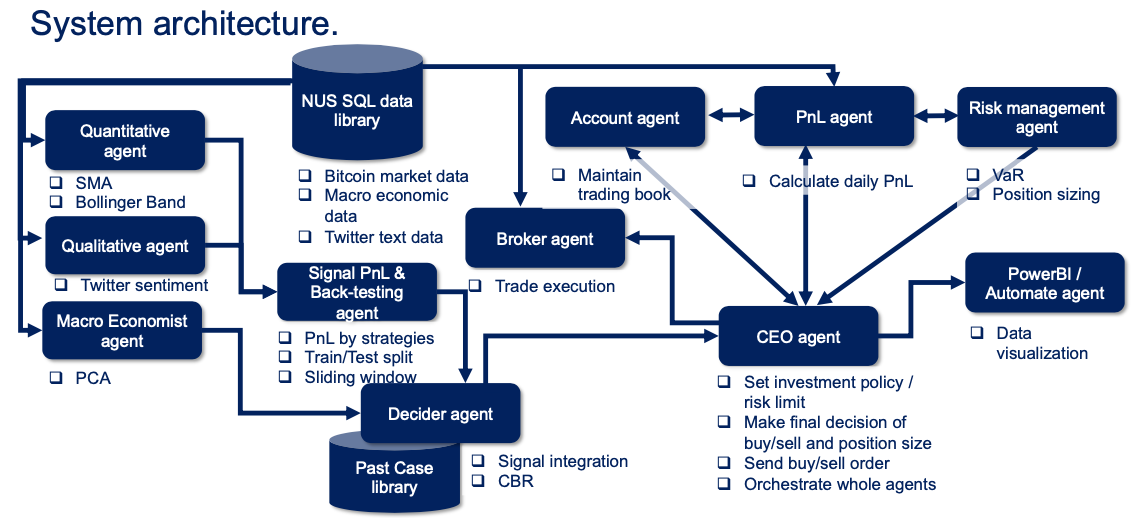

### Brief explanation of each agent

Below is the list of agents that the system incorporates.

* **Account agent:**

 Account agent launches and manages account book data i.e. buy/sell transaction data, PnL data, and Net Asset Value (NAV) data etc.

* **Broker agent:**

 It establishes the connection with market data. Also, it enables the buy/sell trading execution.

* **Quantitative signaling agent:**

 It recommends buy and sell decisions based on simple moving average (SMA) and bollinger band.

* **Qualitative signaling agent:**

 It acquires and analyzes twitter text regarding bitcoin from major news sources and influential person’s accounts (e.g. I picked Elon Musk who often mentions bitcoin), utilizing natural language processing (NLP). Then, the system converts the results from NLP into sentiment indicators then buy and sell recommendations using fuzzy logic.

* **Macro Economist agent:**

 Also, to understand market circumstances at the time, the system utilizes data from macro economics and other asset classes, such as data from equity market, interest rate, commodity market, VIX index and so on. Macro economist agent receives those data and summarizes the market situation with 3 factors, using Principal Component Analysis (PCA).

* **Signal PnL & Backtesting agent:**

 Those agents calculate the trading performance by each signaling agents, i.e. SMA, Bollinger band, and Twitter sentiment. Also, it implements back-testing utilizing train/test data split with sliding-window.

* **Decider agent:**

 Then, the decider agent aggregates those recommendations and macro economic information and makes the final recommendation to the CEO agent. In this process, the system utilizes case-based reasoning (CBR) to store and utilize historical prices, technical signals, and macro factor data with the resulting price direction on the following days. By referring to “same or similar combinations of quantitative and qualitative agent’s buy/sell signal under similar macro economic circumstance”, the CBR allows the trading system to generate better final recommendation. For the implementation of CBR, I utilized k-nearest neighbours (kNN), which is a popular method in machine learning and for implementing CBR.

* **PnL Agent:**

 This agent calculates daily PnL movement and returns it to the Account book and CEO agent.

* **PowerBI / Automate agent:**

 It can establish the connection with PowerBI, which enables us the data visualization of daily Account book and market data. Also, it can enable the automation of sending monthly reports via email by using Power Automate.

* **Risk management agent:**

 It implements Value at Risk (VaR), which is a popular method in market risk management. Also, it can support appropriate position sizing based on VaR metrics.

* **CEO agent:**

 It receives final investment recommendation from decider agent and VaR risk metric report from risk management agent, and decides the final action (buy/sell/do nothing/terminate trading) and position size of trading, based on investment and risk management policy that we set up before the trading as CEO.

### Communication among different agents

Note: Each agent communicate data by getter functions shown as follows. If we would like to trace the communication between different agents, we can refer "Getter functions" section in each agent.

(Below is the example)

In [ ]:
########################
#Getter functions
########################

#Those can become interface
#for communication among
#different agents

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [2]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
# COLAB_PATH = '/content/drive/My Drive/your drive'
# change directory to the path above
# os.chdir(COLAB_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install libraries

Install relevant libraries.

In [3]:
!pip install yfinance
!pip install ccxt
!pip install scikit-fuzzy
!pip install snscrape
!pip install nltk
!pip install stats
!pip install pandas_datareader
!pip install pymysql

     |████████████████████████████████| 6.3 MB 33.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=5127712bf601418cf28223fce30707cbd6c746782a1c98ecb6e69abef47cc975
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 2.0 MB 34.7 MB/s 
     |████████████████████████████████| 1.3 MB 50.9 MB/s 
     |████████████████████████████████| 294 kB 57.2 MB/s 
     |████████████████████████████████| 3.5 MB 41.3 MB/s 
     |████████████████████████████████| 160 kB 56.5 MB/s 
     |████████████████████████████████| 291 kB 56.9 MB/s 
     |████████████████████████████████| 993 kB 30.0 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=

### Import libraries

In [4]:
#libraries for general purpose
from threading import Thread,Lock
import logging
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [5]:
#libraries for market data/broker agent
import ccxt
import yfinance

In [6]:
#libraries for risk management agent
from scipy.stats import norm

In [7]:
#libraries for qualitative agents (i.e. twitter sentiment)
#libraries for text data preprocessing
import nltk
from nltk.corpus import stopwords
import itertools
import re
import string
from textblob import TextBlob

#libraries for google sentiment analysis and fuzzy logic
import skfuzzy as fuzz
from google.cloud import language_v1
from google.cloud.language_v1 import enums
from skfuzzy import control as ctrl
import snscrape.modules.twitter as sntwitter
from time import sleep

In [8]:
#libraries for macro economic data angent
import pandas_datareader.data as web
from random import choice
import scipy.stats as st
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
%matplotlib inline

In [9]:
#libraries for decider agent
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
%matplotlib inline

#libraries for back-testing agent
from sklearn.model_selection import TimeSeriesSplit
import math
import threading

In [10]:
#libraries for email sending
import smtplib, ssl
from email import message
from email.mime import multipart
from email.mime import text
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.header import Header
from email import encoders

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="DATALIBRARY",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

### Setting up Google sentiment analysis tool for qualitative agent

Please obtain relevant json file from google, and place file under the folder that you've set as COLAB_PATH.

In [11]:
#set up for google sentiment analysis tool in Qualitative agent
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'xxxxxxx-xx-xxxxxx.json'
#!echo $GOOGLE_APPLICATION_CREDENTIALS

## Account/NAV management agent

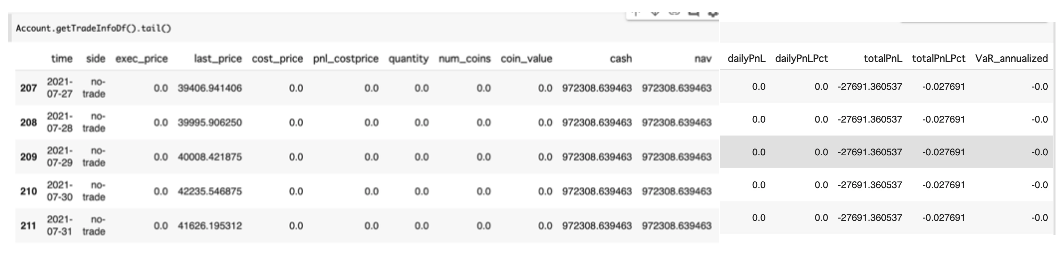

Account agent creates and maintains the account book shown above (Account.trade_info_df). It records daily trading activity (buy/sell/no-trade), purchased/sold price, # of bitcoin holding, NAV (net asset value = cash amount + market value of holding bitcoin), daily PnL, and annualized Value at Risk (VaR), etc. We can regard Account agent as the miniature of the back-office function in asset management companies.


### Code of the agent

In [ ]:
class Account(object):

  #Launch initial starting status of account.
  @staticmethod
  def initialization(num_coins, cash, time):
    Account.num_coins = num_coins
    Account.cash = cash
    #trading symbol used for hitbtc data acquisition
    Account.trading_symbol_hitbtc = 'BTC/USDT'
    #trading symbol used for yahoo data acquisition
    Account.trading_symbol_yahoo = 'BTC-USD'

    Account.trade_info_df = pd.DataFrame(data=[[time, 'no-trade',0,
                                                0, 0, 0,0, num_coins, 0,
                                                cash, cash,
                                                0,0,0,0,0]], 
                                      columns=['time','side', 'exec_price',
                                               'last_price','cost_price','pnl_costprice','quantity', 'num_coins', 
                                               'coin_value', 'cash', 'nav', 'dailyPnL',
                                               'dailyPnLPct','totalPnL', 'totalPnLPct','VaR_annualized'])
  
  @staticmethod
  def getCoins():
    return Account.num_coins
  
  @staticmethod
  def getCash():
    return Account.cash

  @staticmethod
  def setCoins(num_coins):
    Account.num_coins = num_coins

  @staticmethod
  def setCash(cash):
    Account.cash = cash

  #Trade execution can be done by Broker agent.
  #NAV, daily PnL and dailyPnLPct are calculated by PNLAgent.
  @staticmethod
  def recordNewTradeInfo(time, side, exec_price, last_price, cost_price, pnl_costprice,
                         quantity, num_coins, coin_value, cash, nav,dailyPnL, dailyPnLPct,
                         totalPnL, totalPnLPct, VaR_annualized):
    Account.setCoins(num_coins)
    Account.setCash(cash)
    Account.new_trade_info_df = pd.DataFrame(data=[[time, side, exec_price, 
                                                    last_price, cost_price, pnl_costprice,quantity, 
                                                    num_coins, coin_value, cash,
                                                    nav, dailyPnL, dailyPnLPct,
                                                    totalPnL, totalPnLPct, VaR_annualized]], 
                                  columns=Account.trade_info_df.columns)
    Account.trade_info_df = pd.concat([Account.trade_info_df, Account.new_trade_info_df], 
                                   axis=0).reset_index(drop=True)

  @staticmethod
  #NAV, daily PnL and dailyPnLPct are calculated by PNLAgent.
  def updateNoTradeDay(time, exec_price, last_price):
    time = time
    side = 'no-trade'
    exec_price = exec_price
    quantity = 0
    num_coins = Account.trade_info_df['num_coins'].iloc[-1]
    cost_price = Account.trade_info_df['cost_price'].iloc[-1]

    if cost_price == 0:
      pnl_costprice = 0
    else:
      pnl_costprice = last_price / cost_price - 1

    coin_value = last_price * num_coins
    cash = Account.trade_info_df['cash'].iloc[-1]
    #nav, pnl, and VaR are calculated later and we can leave those as zero here
    nav = 0.0
    dailyPnL = 0.0
    dailyPnLPct = 0.0
    totalPnL = 0.0
    totalPnLPct = 0.0
    VaR_annualized = 0.0

    no_trade_info_df = pd.DataFrame(data=[[time, side, exec_price, last_price, cost_price, 
                                           pnl_costprice,quantity, num_coins, coin_value, cash, 
                                           nav, dailyPnL, dailyPnLPct,
                                           totalPnL, totalPnLPct, VaR_annualized]], 
                                  columns=Account.trade_info_df.columns)
    Account.trade_info_df = pd.concat([Account.trade_info_df, no_trade_info_df], 
                                   axis=0).reset_index(drop=True)

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents

  @staticmethod
  def getInitialCoins():
    return float(Account.trade_info_df['num_coins'].values[0])

  @staticmethod
  def getInitialCash():
    return float(Account.trade_info_df['cash'].values[0])

  @staticmethod
  def getTradeInfoDf():
    return Account.trade_info_df

In [ ]:
Account.initialization(0,1000000,datetime.datetime(2021,1,1))

In [ ]:
Account.getTradeInfoDf()

time      side  exec_price  ...  totalPnL  totalPnLPct  VaR_annualized
0 2021-01-01  no-trade           0  ...         0            0               0

[1 rows x 16 columns]

## Broker agent

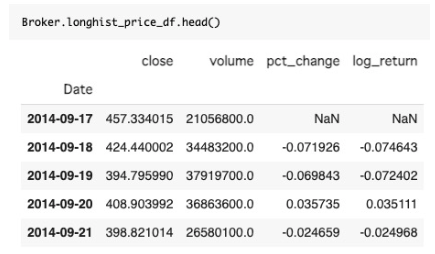

Broker agent handles market data acquisition and buy/sell trading execution.

* **1.Market data acquisition**
 
 In terms of collecting market information, Broker class has the ability to get both historical and real time cryptocurrency price and trade information. When I started the system development, I gathered price data from yahoo finance and market exchange such as hitbtc using ccxt library. Then, NUS Fintech Lab decided to launch a SQL data library, such that I implemented a broker agent such that the system obtains data from MySQL data library. So far, this data library obtains daily OHLCV (Open-High-Low-Close-Volume) data from yahoo finance. 

 (Note: Through market exchanges using ccxt, we can obtain only recent data from around 2017. On the other hand, we can obtain bitcoin OHLCV data from 2014 by yahoo finance. For daily market analysis, at least we need 5-6 years of data. With such a background, yahoo finance is used as the data source this time.)

 Broker agent maintains price data as Broker.longhist_price_df shown below. The system only uses closing prices, such that this dataframe just stores closing price data and daily volume. Then, the system adds day to day percent change and log-return too.
 
 (Note: For back-test purposes, industry practitioners often use log return, because it’s easy to calculate cumulative return just by adding daily log return.)

* **2.Trading execution**

 In terms of executing decisions, Broker agent has the ability to initialize the trade information stored in the Account Class, execute the trade according to the final decision made by the CEO agent, and update the account information.

 With regard to the trading execution, as the simulation logic, the system assumed 0.1% of spread from closing price, i.e. we need to buy 0.1% higher than market close, while we need to sell 0.1% lower than market price. In the future, if NUS Fintech Lab establishes simulated market exchange or directly trades real money at market exchange, a successor can modify Broker agent by which the system enables us to buy/sell at the simulated or real market exchange.



### Code of the agent

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  #get price data from yahoo finance
  #just for your reference. After we implemented getPriceFromDataLibrary(),
  #we don't use this function.
  '''
  @staticmethod
  def get_yahoo_hist_ohlcv_data(ticker, startday, endday):
    ohlcv_df = yfinance.download(ticker, start=startday, end=endday)\
                  .drop('Adj Close',axis=1)
    ohlcv_df['currency'] = ticker
    ohlcv_df = ohlcv_df[['currency','Open','High','Low','Close','Volume']]
    ohlcv_df.index = ohlcv_df.index.astype('datetime64[ns]')
    ohlcv_df.columns = ['currency','open','high','low','close','volume']
    # Data cleaning (if nan, fill in by previous day's price)
    ohlcv_df = ohlcv_df.fillna(method='ffill')
  
    return ohlcv_df
  '''

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  #Obtain trading start day from Account
  @staticmethod    
  def getInitialDay():
    initialDay = Account.getTradeInfoDf()['time'].iloc[0]
    return initialDay

  '''
  #########################
  #market data acquisition and execution from hitbtc.
  #Just for reference purpose.
  #After we implemented SQL data library, 
  #we don't use ccxt downloading function.
  #########################

  @staticmethod
  def get_ohlcv_data(trading_symbol_hitbtc, candlestick_timeframe, limit=100):
      ohlcv = Broker.hitbtc.fetch_ohlcv(trading_symbol_hitbtc, candlestick_timeframe, 
                                        limit=limit, params={'sort': 'DESC'})
      df = pd.DataFrame(ohlcv, columns=['Date', 'open', 'high', 'low', 'close', 'volume'])
      df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
      df.index = df.set_index('Date',drop=True).index.astype('datetime64[ns]')
      return df

  @staticmethod
  def get_mid_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return ((float)(ticker['info']['bid']) + (float)(ticker['info']['ask']))/2

  @staticmethod
  def get_bid_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return (float)(ticker['info']['bid'])

  @staticmethod
  def get_ask_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return (float)(ticker['info']['ask'])

  #Place order at the current price, current time
  #nav, dailyPnL, dailyPnLPct are calculated by PnLAgent
  @staticmethod
  def tradeExecutionNow(side, quantity,nav, dailyPnL, dailyPnLPct, 
                        totalPnL,totalPnLPct, VaR_annualized):
    
    #when we buy, buy at ask price,
    #when we sell, sell at bid price.
    bid_price = Broker.get_bid_price(Account.trading_symbol_hitbtc)
    ask_price = Broker.get_ask_price(Account.trading_symbol_hitbtc)

    if side == 'buy':
      exec_price = ask_price
    elif side == 'sell':
      exec_price = bid_price
    
    time = Broker.getCurrentDate()

    Broker.tradeExecution(time,side, exec_price, quantity, nav, dailyPnL, 
                          dailyPnLPct, totalPnL,totalPnLPct, VaR_annualized)
  '''

  ###########################
  #Functions for pseudo bid/ask data acquisition
  #we set as follows:
  #bid price: close price minus 0.1%
  #ask price: close price plus 0.1%
  ###########################

  #pseudo price is used for simulation
  @staticmethod
  def get_pseudo_mid_price(day):
      return float(Broker.longhist_price_df.loc[day,'close'])

  #pseudo price is used for simulation
  @staticmethod
  def get_pseudo_bid_price(day, spread = 0.001):
      return float(Broker.longhist_price_df.loc[day, 'close']) * (1.0 - spread)


  #pseudo price is used for past simulation
  @staticmethod
  def get_pseudo_ask_price(day, spread=0.001):
      return float(Broker.longhist_price_df.loc[day,'close']) * (1.0 + spread)

  @staticmethod
  def getCurrentDate():
    return datetime.date.today()

  @staticmethod
  def getPseudoCurrentDate(index):
      return Broker.longhist_price_df.iloc[index]['time']

  # Place the order
  #nav, dailyPnL, dailyPnLPct are calculated by PnLAgent
  @staticmethod
  def tradeExecution(time,side, exec_price, quantity, nav, 
                     dailyPnL, dailyPnLPct, totalPnL,totalPnLPct, 
                     VaR_annualized):
      exec_price = float(exec_price)
      #last price is set as exec_price temporarilly.
      #After the execution of trade, last_price can be updated by PNLAgent.
      last_price_temp = float(exec_price)
      num_coins = Account.getCoins()
      cash = Account.getCash()
      if side == 'buy':
          if cash < exec_price*quantity:
              quantity = float(cash/exec_price)

          num_coins_old = num_coins
          cost_price_old = Account.getTradeInfoDf()['cost_price'].iloc[-1]
          num_coins = num_coins + quantity
          #cost price is the weighted average of new position of execution price and buying
          #quentiti, and existing position and cost price          
          cost_price = (exec_price * quantity + cost_price_old * num_coins_old) / num_coins
          cash = cash - exec_price*quantity
      elif side == 'sell':
          if num_coins < quantity:
              quantity = num_coins
          num_coins = num_coins - quantity
          cash = cash + exec_price*quantity
          #if selling all position, reset cost price
          if num_coins == 0:
            cost_price = 0
          else:
            cost_price = Account.getTradeInfoDf()['cost_price'].iloc[-1]
      #calculate current pnl % from cost price
      if cost_price == 0:
        pnl_costprice = 0
      else:
        pnl_costprice = last_price_temp / cost_price - 1

      #NAV is calculated by PNLAgent.
      coin_value = last_price_temp * num_coins
      Account.recordNewTradeInfo(time, side, exec_price, last_price_temp, cost_price, pnl_costprice,
                                 quantity, num_coins, coin_value, cash, nav, dailyPnL, 
                                 dailyPnLPct,totalPnL,totalPnLPct, VaR_annualized)

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
Broker.longHistoryPriceGetter().head()

close      volume  pct_change  log_return
Date                                                      
2014-09-17  457.334015  21056800.0         NaN         NaN
2014-09-18  424.440002  34483200.0   -0.071926   -0.074643
2014-09-19  394.795990  37919700.0   -0.069843   -0.072402
2014-09-20  408.903992  36863600.0    0.035735    0.035111
2014-09-21  398.821014  26580100.0   -0.024659   -0.024968

## PnL agent

Based on the raw data collected and recorded by the Account and Broker agent, PNL agent is the one who calculates and updates NAV and PnL information in the account book which is created and maintained by Account agent.


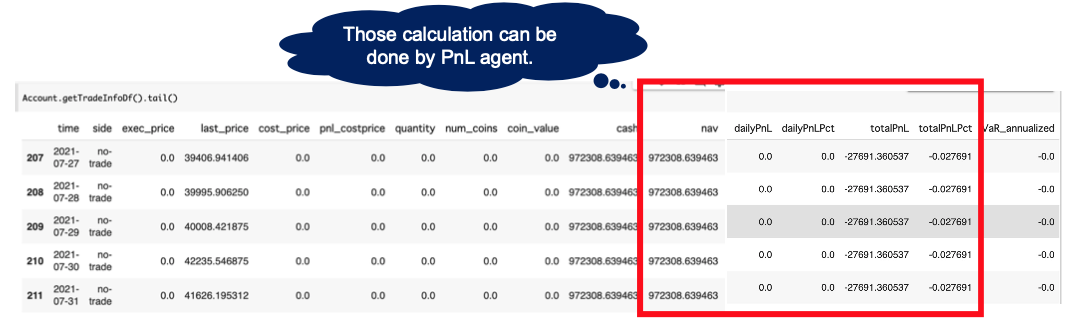

### Code of the agent

In [ ]:
class PNLAgent(object):

  ####################
  #Functions to get basic data
  ####################

  #Obtain trading start day from Account
  @staticmethod    
  def getInitialDay():
    PNLAgent.initialDay = Account.getTradeInfoDf()['time'].iloc[0]
    return PNLAgent.initialDay

  @staticmethod
  def getInitialNAV():
    return float(Account.getTradeInfoDf().loc[0, 'nav'])

  @staticmethod
  def getTodayNAV(day):
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]

    return float(Account.getTradeInfoDf().loc[indexRow, 'nav'])

  #Update daily last price
  @staticmethod
  def updateLastPrice(day):
    last_price = Broker.longHistoryPriceGetter().loc[day,'close']
    Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day,['last_price']] = last_price

    #update pnl_costprice after updating last price
    cost_price = Account.getTradeInfoDf()['cost_price'].iloc[-1]
    if cost_price == 0:
      pnl_costprice = 0
    else:
      pnl_costprice = last_price / cost_price - 1

    Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day,['pnl_costprice']] = pnl_costprice

  ####################
  #Compute Net Asset Value (NAV) and return
  ####################

  #compute daily nav
  #e.g. index = datetime.datetime(2021, 1, 2)
  @staticmethod
  def calculateNAV(day):

    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]

    coins = Account.getTradeInfoDf().loc[indexRow,'num_coins']
    price = Account.getTradeInfoDf().loc[indexRow,'last_price']
    cash = Account.getTradeInfoDf().loc[indexRow, 'cash']
    coin_value = coins * price
    Account.getTradeInfoDf().loc[indexRow, 'coin_value'] = coin_value
    NAV = coin_value + cash
    Account.getTradeInfoDf().loc[indexRow, 'nav'] = NAV

    if indexRow == 0:
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] = 0
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnLPct'] = 0.0
      Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] = 0.0
      Account.getTradeInfoDf().loc[indexRow, 'totalPnLPct'] = 0.0

    else:
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] = Account.getTradeInfoDf().loc[indexRow, 'nav'] - \
              Account.getTradeInfoDf().loc[indexRow-1, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnLPct'] = Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] / \
              Account.getTradeInfoDf().loc[indexRow-1, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] = Account.getTradeInfoDf().loc[indexRow, 'nav'] - \
              Account.getTradeInfoDf().loc[0, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'totalPnLPct'] = Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] / \
              Account.getTradeInfoDf().loc[0, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'VaR_annualized'] = riskManagement.portVaRCalc(day)

  #Compute total return since trading inception.
  @staticmethod
  def computePnLSinceInception():
    return (Account.getTradeInfoDf()['nav'].iloc[-1] - Account.getTradeInfoDf()['nav'].iloc[0])/ \
            Account.getTradeInfoDf()['nav'].iloc[0]

## Quantitative agents

As a quantitative signaling agent, I implemented two different trading strategies, using different technical indicators. One is SMA crossover strategy, and the other is Bollinger bands strategy.

### Simple Moving Average (SMA)

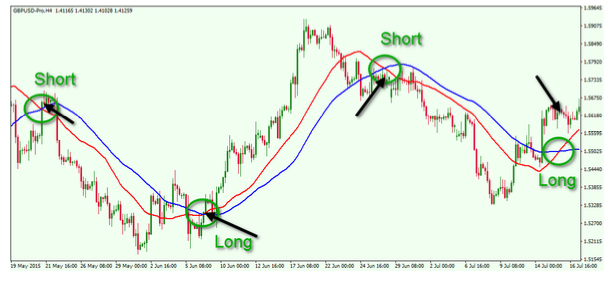

(Source: https://forextraininggroup.com/anatomy-of-popular-moving-averages-in-forex/)

* **Simple Moving Average (SMA)**
 
 SMA is one of the most popular and common technical indicators in the technical analysis field. SMA is the average price over a given number of time periods. Then, we defined the golden-cross and death-cross.

* **Golden cross**

 The golden-cross occurs when the short-term moving average (short-term MA) price goes over long-term moving average (long-term MA) to the upside and is interpreted as buying opportunities.

* **Death cross**

 Similarly downside moving average crossover constitutes the death-cross and is understood to signal a downturn in a market.
 
* **Popular Trend-following strategy**
 
 - SMA trading strategy is recognized as one of the most popular “trend-following strategies”. Trend-following strategy can perform well if the underlying asset class often shows strong and long-term upward and downward trends.
 - On the other hand, trend-following strategies can perform poorly if the market is within a narrow range i.e. consolidation. Daily trading signal data can be stored at the dataframe of self.agent1_hist_signal_df, and the decider agent will receive trading signal data from this dataframe.

Note:

To achieve versatility i.e. for the back-testing agent can calculate past return and risk not only for SMA agent but also for any other style of quantitative / qualitative agents, each signaling agents need to create below columns and pass those to back-testing agent:

* "long-signal" = [1(=start buying), 0(=do nothing/continue current long position), -1(=exit from current long position)]

* "short-signal" = [1(=start shorting), 0(=do nothing/continue current short position), -1(=exit from current short position)]

### Bollinger Bands

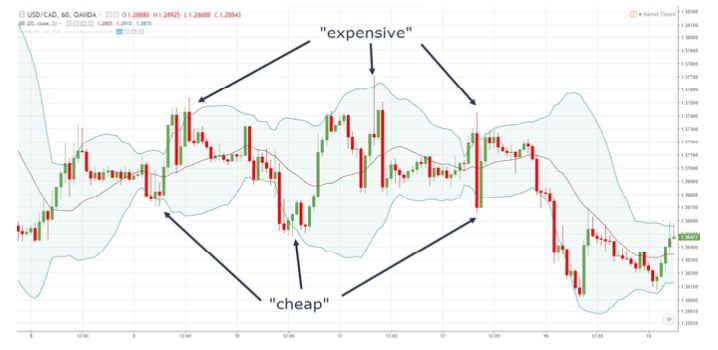

(Source:https://www.tradingwithrayner.com/bollinger-bands-trading-strategy/)

* **Bollinger Bands**
 - Bollinger Bands® are a technical analysis tool developed by John Bollinger for generating oversold or overbought signals.
 - There are three lines that compose Bollinger Bands: A simple moving average (middle band) and an upper and lower band. The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average, but can be modified.

* **Logic of Bollinger Bands**

  - If the price goes up beyond the upper band, it is recognized as expensive such that it is a “sell” opportunity.
  - As opposed, if the price goes down below the lower band, it is recognized as cheap such that it is a “buy” opportunity.
  - We can set exit rules differently. For example, many practitioners set exit points when the price reverts back to the moving average. Or, we can also set exit points when the price reverts back between upper and lower bands. The system applies the latter rule for the exit.

* **Mean-reversion strategy**

 As you can see, the above trading rule is based on the assumption of “mean reversion”, i.e. after the price goes up extremely it can go down and vice versa. Hence, this strategy can work well, when the market is in range bound i.e. in consolidation. On the other hand, when there exists a strong and long-term upward or downward trend, such a mean-reverting strategy cannot work well.


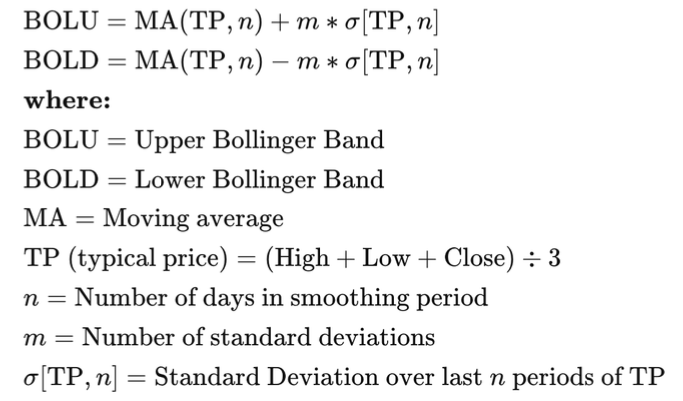

(Source: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/)

* Above formulas are the formal notation of bollinger bands. In practice, TP can be simplified just by close price, such that the system applies this practically simple approach.

* In the back-test optimization, the system implements greedy search from the search space of n = [10, 20] and m = [2.0, 3.0].

* Daily trading signal data can be stored at the dataframe of self.agent2_hist_signal_df, and the decider agent will receive trading signal data from this dataframe.


### Code of the agent

In [ ]:
class quantsSignal():

  #initialization.
  #backtest=False: day-to-day trading
  #backtest=True: signal for backtest
  def __init__(self,backtest=False):
    self.agent1_hist_signal_df = pd.DataFrame()
    self.agent2_hist_signal_df = pd.DataFrame()
    self.backtest = backtest

  #Function to create moving average.
  def movingAvg(self,df,day, short_term, long_term):
    #rolling short-term moving average
    df['ma_short'] = df['close'].rolling(window=short_term).mean()
    #rolling long-term moving average
    df['ma_long'] = df['close'].rolling(window=long_term).mean()

    #create signal
    #Golden cross -> Buy signal
    df['long_signal'] = np.where(df['ma_short'] > df['ma_long'], 1, 0)

    #Death cross -> Sell signal
    df['short_signal'] = np.where(df['ma_short'] < df['ma_long'], 1, 0)

    #output only relevant data
    mvgAvg_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    mvgAvg_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent1_hist_signal_df) == 0:
      self.agent1_hist_signal_df = mvgAvg_df
    #else, update data on historical signaling dataframe
    else:
      self.agent1_hist_signal_df = pd.concat([self.agent1_hist_signal_df,
                                                      mvgAvg_df])

    self.agent1_hist_signal_df = Broker.addPctChg(self.agent1_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent1_hist_signal_df = self.agent1_hist_signal_df[~self.agent1_hist_signal_df.index.duplicated(keep='first')]

  def movingAvgDailyUpdate(self, day, short_term, long_term):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.movingAvg(df,day, short_term, long_term)

  #Function to create bollinger band.
  def bollingerBand(self, df, day, data_window=20, std_dev=2):
    #rolling x days moving average
    df['ma'] = df['close'].rolling(window=data_window).mean()
    #rolling x days standard deviation
    df['std'] = df['close'].rolling(window=data_window).std()
    #bollinger band lower band: x standard deviation from moving average
    df['low_band'] = df['ma'] - df['std'] * std_dev
    #bollinger band higher band: x standard deviation from moving average
    df['high_band'] = df['ma'] + df['std'] * std_dev

    #create trading signal

    #close price go higher than higher band, it's regarded as overbought,
    #such that it's sell signal.
    df['short_signal'] = np.where(df['close'] > df['high_band'], 1, 0)

    #close price go lower than lower band, it's regarded as oversold,
    #such that it's buy signal.
    df['long_signal'] = np.where(df['close'] < df['low_band'], 1, 0)

    #output only relevant data
    bollinger_df = df.loc[day, ['close','long_signal','short_signal']].to_frame().T
    bollinger_df.index.names = ['Date']

    #if no prior data, initialize historical signaling dataframe
    if len(self.agent2_hist_signal_df) == 0:
      self.agent2_hist_signal_df = bollinger_df
    #else, update data on historical signaling dataframe
    else:
      self.agent2_hist_signal_df = pd.concat([self.agent2_hist_signal_df,
                                                      bollinger_df])
      
    self.agent2_hist_signal_df = Broker.addPctChg(self.agent2_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent2_hist_signal_df = self.agent2_hist_signal_df[~self.agent2_hist_signal_df.index.duplicated(keep='first')]

  def bollingerDailyUpdate(self, day, data_window=20, std_dev=2):
    tMinus50 = day + datetime.timedelta(days=-50)
    df = Broker.longHistoryPriceGetter().loc[tMinus50:day,:]
    self.bollingerBand(df, day, data_window, std_dev)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def agent1SignalGetter(self):
    return self.agent1_hist_signal_df

  def agent2SignalGetter(self):
    return self.agent2_hist_signal_df

## Qualitative signaling agent (Twitter agent)

Qualitative anget is the agent which formulates buy/sell signals based on qualitative data such as text. In our implementation, we try to formulate buy/sell signals by analyzing twitter text sentiment and converting those into trading buy/sell signals, by implementing Twitter agent.

### 1.Data acquisition

* **Data Acquisition**
 
 First of all, we should obtain text data regarding bitcoin from twitter. As the text scraping tool for twitter, it looks that “tweepy” is widely used by many students in past IS5006 class. However, it has the limitation of data acquisition, such as the limitation of available data only for recent 7 days, etc. Considering such limitations, this time, the system applied the “snscrape” library to obtain tweet data several years ago.

* **Set scope of data**

 Next, we need to set the scope of data acquisition. While we may be able to reach great insight by collecting all worldwide tweets regarding bitcoin and cryptocurrencies, gathering such tremendous amounts of data is computationally too expensive.
 
 Also, as we gather tweets from less popular and unreliable accounts, the quality of information can saturate and the amount of noise in text information can increase. With regard to this point, the sentiment of popular twitter news accounts such as NYTimes, Bloomberg, CNN News, etc, have high correlation with market price. Based on those surveys, this time, we have chosen Wall Street Journal (WSJ), Bloomberg, Investing.com, CNN, NYTimes, Financial Times (FT), and Elon Musk.
 
 Elon Musk is not the news media but an individual, but nowadays his tweet has influential power toward bitcoin and other cryptocurrency’s price, such that I included his twitter account within data gathering scope.
 
 I collected data from 2014 with 7612 tweets, but many of the tweets are recent one after 2018, when bitcoin price showed a bubble and burst with large price movement. Then, we added those data into SQL data library. The system obtains those data from SQL database then stores data into the dataframe of self.tweets_hist_df.

### 2.Data preprocessing

In text sentiment analysis, data preprocessing takes a very important part. 

* **Cleaning up the texts**

 First of all, we need to clean up twitter text. For example, we remove strings starting with “@”, “#”, “$”. Also, we remove hyperlinks and URL, video, and “RT”, etc, the words which are not important to evaluate the sentiment.


* **Eliminating stop words**

 Also, we can eliminate stop-words. Stop-words means meaningless words such as “a”, “the”, “of”, and so on. The system executes those tasks by the functions of clean_tweet_text(self, tweetText) and removeStopwords(self, text), when twitterSignal class executes the function of dataPreprocessing(self).
 
 When we deal with stopwords, nltk (Natural Language ToolKit) library is popularly used, so I introduced it in the system implementation. Those preprocessing can remove noise in text data, such that it affects the quality of sentiment analysis significantly.

### 3.Data transformation

In addition to the data preprocessing, we can transform text data to convert those into quantified sentiment data.

* **Textblob**

 For example, I introduced sentiment measurement of “polarity” and “subjectivity” by using the textblob library.Obtaining polarity and subjectivity by using textblob is a very simple, but powerful way to start text sentiment analysis.
 
 - Polarity is a float within the range [-1.0, 1.0], where 1 means positive statement and -1 means a negative statement.
 
 - Subjectivity is a float within the range [0.0, 1.0] where 0 is objective and 1.0 is subjective. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. 

* **Google Text Analytics**

 To move one step ahead for the text sentiment analysis, the system utilized Google Text Analytics in the function of googleSentiment(self, df). By utilizing this function, we can obtain text sentiment metrics such as “score” and “magnitude”.

 - Score: It ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

 - Magnitude: It indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes). 

 In addition, by using Google Text Analytics, we can obtain other information such as the category of the topic that the text mentions (e.g. finance, leisure, etc). As a result, we can gather data shown as follows.



### 4.Fuzzy logic

After obtaining sentiment metrics by using google text analytics, the system implements the fuzzy logic to convert “score” and “magnitude” into one integrated sentiment indicator of “strength”.

* First, we set membership functions for score, magnitude, and strength. For example, by setting membership functions for score and magnitude, we can define “how much of the score is regarded as low score i.e. negative, how much is mediocre i.e. neutral, and how much is positive” in a “fuzzy” manner.

* Then, the fuzzy logic can output the final integrated sentiment outcome as “strength” by combining “score” and “magnitude”.

Fuzzy-logic is a relatively old idea which was introduced around 1965 and used for the temperature control of rice cookers and electric ovens. However, it is still useful when we deal with “vague” recognition, such as “hot” or “cold” for rice cookers and “positive” and “negative” in text tone. By utilizing fuzzy logic, we can deal with the vagueness in the use of language such as “positive” or “negative” tone in text.

### Final outcome

Finally, we can obtain a “strength” sentiment indicator between 0-100, shown below in the graph.

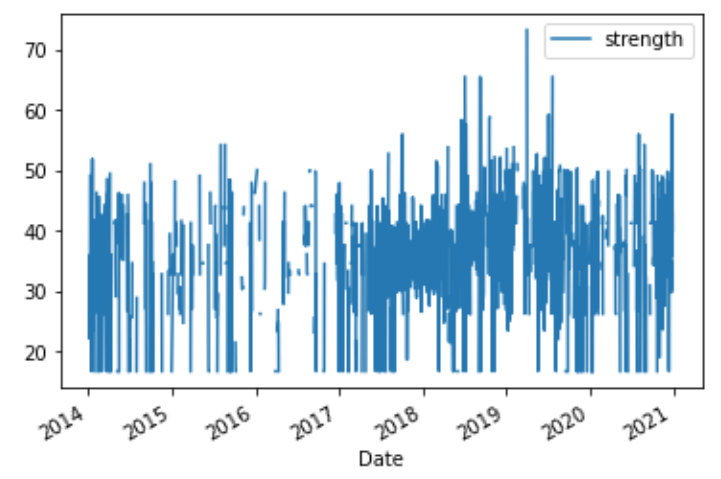

### Code of the agent

In [ ]:
class twitterSignal():

  ###########################
  #Twitter text data related
  ###########################
  #For stopword operation.
  nltk.download('stopwords')

  #initilization by obtaining past some days of data
  def __init__(self, day, backtest=False):

    #set backtest / realtime mode
    self.backtest = backtest

    #initialize dataframes
    self.agent3_hist_signal_df = pd.DataFrame()
    self.sentiment_history_df = pd.DataFrame()
    self.tweets_df = pd.DataFrame()

    self.twitterTextInitialization()
    
    #In trading mode, we obtain recent data and do data preprocessing 
    #and fuzzy logic to obtain recent twitter indicator
    if self.backtest == False:
      #collect last 10 days of twitter sentiment data
      start = day + datetime.timedelta(days=-11)
      end = day + datetime.timedelta(days=-1)

      self.textAcquisition(start, end)
      self.dataPreprocessing()
      self.fuzzyLogic()

  '''
  #############################
  #It's just for reference to obtain twitter data from scratch.
  #After implementing SQL inhouse data library, we won't use it.
  #############################

  #it takes very long time to obtain many years of twitter data.
  #so, we download data only once and save it as csv file.
  def backtestDataAcquisition(self):

    self.sentiment_history_df = pd.DataFrame()

    for year in range(2014,2021):
      start = datetime.datetime(year,1,1)
      end = datetime.datetime(year,12,31) + datetime.timedelta(Days=1)

      self.textAcquisition(start, end)
      self.dataPreprocessing()
      self.fuzzyLogic()
      self.tweets_df.to_csv('twitter_data/twitterdata_{}.csv'.format(year))
      print('twitter year {} is downloaded'.format(year))

    self.sentiment_history_df.to_csv('twitter_data/fuzzysentimentdata.csv')

  #Twitter data acquisition tool
  #Once NUS database is completed, we won't use it
  def textAcquisition(self, startday, endday):

    #convert datetime into text format
    startday = startday.strftime('%Y-%m-%d') 
    endday = endday.strftime('%Y-%m-%d') 
    #set the num of break iteration
    break_iter = 9999
    #empty list for twetter data storing.
    tweets_list = []
    #It's column list for pd dataframe.
    column_list = ['crypto','url','date','id', 'username', 'content']
    #so far, we set only popular cryptos.
    word_list = ['bitcoin', 'btc']
    #We extract data only from low noise, high quality news media's accounts.
    #note: 'business' is bloomberg's official news account.
    account_list = ['WSJ','business','Investingcom','CNN','nytimes','FT','elonmusk']

    for search in itertools.product(word_list,account_list):
      #example of search_word: 'bitcoin from:WSJ since:2013-01-01 until 2020-12-31'
      search_word = str(search[0]) + ' from:' + str(search[1]) + ' since:' + startday + ' until:' + endday
      for i, tweet in enumerate(sntwitter.TwitterSearchScraper(search_word).get_items()):
        if i> break_iter:
            break
        tweets_list.append([search[0], tweet.url, tweet.date,tweet.id, tweet.username, tweet.content])
      
    if len(tweets_list) == 0:
      tweets_list.append([np.nan,np.nan,startday,np.nan, np.nan, np.nan])
    
    self.tweets_df = pd.DataFrame(tweets_list, columns=column_list).sort_values('date')
  '''

  #obtain twitter data from SQL data library and data preprocessing
  def twitterTextInitialization(self):
    dbConnection = sqlEngine.connect()
    self.tweets_hist_df = pd.read_sql("select * from Tweets", dbConnection).sort_values('date').reset_index(drop=True)
    dbConnection.close()

  #getter of twitterAgent.tweets_df
  def textAcquisition(self, start, end):
    startday = start
    endday = end + datetime.timedelta(days=1)
    self.tweets_df = self.tweets_hist_df[(self.tweets_hist_df['date'] >= startday) &  (self.tweets_hist_df['date'] <= endday)]

    if len(self.tweets_df) == 0:
      self.tweets_df.loc[0] = np.nan
      self.tweets_df.loc[0,'date'] = startday

  ###########################
  #Text data preprocessing
  ###########################

  def dataPreprocessing(self):
    
    #if there is text data in certain day, below is executed
    try:
      #add text length for twitter data
      self.tweets_df['text_length'] = self.tweets_df['content'].apply(len)
      #Apply clean_up_tweet and removeStopwords to twitter's text
      self.tweets_df['content_processed'] = self.tweets_df['content']\
                                                    .apply(self.clean_tweet_text)\
                                                    .apply(self.removeStopwords)
      #Add polarity and subjectivity
      self.tweets_df['polarity'] = self.tweets_df['content_processed'].apply(self.get_text_polarity)
      self.tweets_df['subjectivity'] = self.tweets_df['content_processed'].apply(self.get_text_subjectivity)
      self.tweets_df['label'] = self.tweets_df['polarity'].apply(self.get_text_analysis)
      #add text length for twitter data
      self.tweets_df['text_processed_length'] = self.tweets_df['content_processed'].apply(len)
      #Add google sentiment data
      result_df = self.googleSentiment(self.tweets_df)
      self.tweets_df = self.tweets_df.merge(result_df, how='inner', on=result_df.index).drop('key_0', axis=1)

    #when no text data is available, it returns error and transact as follows
    except:
      self.tweets_df[['text_length','content_processed','polarity','subjectivity',
                      'label','text_processed_length']] = np.nan

  #Preprocessing 1...text clearning tool which is unique for twitter text
  def clean_tweet_text(self, tweetText):
    # Change all characters to lower case
    tweetText = tweetText.lower() 
    # Remove any strings starting with a "@"
    tweetText = re.sub("@[A-Za-z0-9]+", "", tweetText) 
    # Remove any strings starting with a "#"
    tweetText = re.sub("#[A-Za-z0-9]+", "", tweetText) 
    # Remove any strings starting with a "$"
    tweetText = re.sub("\$[A-Za-z]+", "", tweetText) 
    # Remove the "\n" string
    tweetText = re.sub("\\n", " ", tweetText) 
    # Remove any hyperlinks
    tweetText = re.sub("https?:\/\/\S+", "", tweetText) 
    # Remove url/website that didn't use http, is only checking for .com websites,
    # so words that are seperated by a . are not removed
    tweetText = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', tweetText)
    # Remove {link}
    tweetText = re.sub(r'{link}', '', tweetText) 
    # Remove &text; html chars
    tweetText = re.sub(r'&[a-z]+;', '', tweetText) 
    # Remove [video]
    tweetText = re.sub(r"\[video\]", '', tweetText) 
    # Remove all remaining characters that aren't letters, white space, or 
    #the following #:)(/\='] that are used in emojis or hashtags
    tweetText = re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];='#$]", '', tweetText)
    # Remove retweets:
    tweetText = re.sub(r'RT : ', '', tweetText)

    # Return the cleaned tweet text to the caller
    return tweetText

  #Preprocessing 2...removing stop-words i.e. a, the, of, etc
  #function to execute removing stopwords.
  def removeStopwords(self, text): 
    stop = stopwords.words('english')

    text = text.lower()
    regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n'+']')
    txt = regex.sub('',text)  #remove punctuation
    # remove stop words and words with length smaller than 3 letters
    words = [w for w in txt.split(' ') if w not in stop] 
    words = ' '.join(word for word in words)

    return words

  ###########################
  #Data transformation
  #Subjectivity and polarity data
  ###########################

  #subjectivity: [0,1]. 0=objective fact, 1=subjective opinion
  def get_text_subjectivity(self, txt):
      return TextBlob(txt).sentiment.subjectivity

  #polarity:[-1,1]. -1=very negative tone, +1=very positive tone.
  def get_text_polarity(self, txt):
      return TextBlob(txt).sentiment.polarity

  # categorize our tweets as Negative, Neutral and Positive.
  #1=very negative, 5=very positive
  def get_text_analysis(self, polarity):
      if (polarity < 0 and polarity > -0.5):
          return 2
      elif polarity <= -0.5:
          return 1
      elif polarity == 0:
          return 3
      elif (polarity > 0 and polarity < 0.5):
          return 4
      else:
          return 5

  ###########################
  #Data transformation
  #Sentiment analysis by google text analyzer
  ###########################

  #google sentiment function
  def googleSentiment(self, df):

    # setup a client for the service
    client = language_v1.LanguageServiceClient()

    # specify the type and language of the document we want to analyse
    type_ = enums.Document.Type.PLAIN_TEXT
    language = "en"
    result_df_score_mag = pd.DataFrame(columns= ['tweet_num','score','magnitude'])

    for index, row in df.iterrows():
      text_content = row['content']

      # assign metadata parameters
      document = {"content": text_content, "type": type_, "language": language}
      encoding_type = enums.EncodingType.UTF8

      # invoke the analyze_sentiment API
      response = client.analyze_sentiment(document, encoding_type)
      # invoke the analyze_entities API for bonus 2
      # i.e. adding insight regarding what the tweet is about. Example: Phone, Organisation etc.
      entities_response = client.analyze_entities(document, encoding_type)

      # invoke classify_text API for bonus 2
      # i.e. adding insight regarding category, such as finance, investing, currencies etc,
      detected_categories = None
      try:
        categories_response = client.classify_text(document)
        
        categories = set()
        for category in categories_response.categories:
          categories.add(category.name)

        detected_categories = ",".join(categories)
      
      #if we cannot find any categories, we just pass it
      except:
        pass

      # simple method used to slow down the requests due to too many requests error
      sleep(0.2) 
      
      entity_types = set()
      for entity in entities_response.entities:
        entity_types.add(enums.Entity.Type(entity.type).name)

      # store the score and magnitude values into result_df_score_mag
      temp_df = pd.DataFrame([[index,
                              response.document_sentiment.score,
                              response.document_sentiment.magnitude, 
                              entities_response.language,
                              ','.join(entity_types),
                              detected_categories
                              ]], 
                            
                              columns=['tweet_num',
                                      'score',
                                      'magnitude', 
                                      'google_language',
                                      'google_entities',
                                      'google_categories'])
      result_df_score_mag = result_df_score_mag.append(temp_df, ignore_index=True)

    return result_df_score_mag

  #By fuzzy logic, converting google sentiment (score, magnitude) into
  #one indicator of 'strength' between 0 (negative) - 100 (positive).
  #'strength' can be used for trading buy/sell recommendation.
  #i.e. if strength > certain figure, buy.
  #     if strength < certain figure, sell.
  def fuzzyLogic(self):
    #if no text data available, just return nan for sentiment indicator
    if self.tweets_df.iloc[0,:].isna().sum() > 5:
      
      self.sentiment_dailyavg_df = pd.DataFrame(data=[['BTC-USD',np.nan]],
                                                        index=self.tweets_df['date'],
                                                        columns=['currency','strength'])
      self.sentiment_dailyavg_df.index.names = ['Date']

    #else, implement fuzzy logic and return sentiment indicator value of 0-100
    else:
      #check if there is relevant twitter text within the day.
      #If no tweet, we fill sentiment data as N/A
      #if len(twitterAgent.tweets_df) == 0:
      #  twitterAgent.sentiment_dailyavg_df = pd.DataFrame[columns=['currency','strength']]

      #Antecedent: score and magnitude 
      #Consequence: sentiment strength

      #Setup:
      #- Score is -1 to 1 with 0.1 step
      #- Magnitude is 0 to 2.0 with 0.1 step
      #- Strength is 0 to 100, with step = 1
      score = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'score')
      magnitude = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'magnitude')
      strength = ctrl.Consequent(np.arange(0, 101, 1), 'strength')

      #Setting membership function for the score
      score['low'] = fuzz.trimf(score.universe, [-1, -1, 0])
      score['moderate'] = fuzz.trimf(score.universe, [-1.0, 0, 1.0])
      score['high'] = fuzz.trimf(score.universe, [0, 1, 1])

      #setting membership function for the magnitude
      magnitude['low'] = fuzz.trimf(magnitude.universe, [0, 0, 1.0])
      magnitude['moderate'] = fuzz.trimf(magnitude.universe, [0, 1.0, 2.0])
      magnitude['high'] = fuzz.trimf(magnitude.universe, [1.0, 2.0, 2.0])

      #setting membership function for the strength
      strength['low'] = fuzz.trimf(strength.universe, [0, 0, 50])
      strength['moderate'] = fuzz.trimf(strength.universe, [0, 50, 100])
      strength['high'] = fuzz.trimf(strength.universe, [50, 100, 100])

      #The rules are as follows:
      #- Strength will be high if
      #  - Both score and magnitude are high
      #  - Score is high and magnitude is average
      #- Strength will be moderate if
      #  - Score is high but magnitude is low
      #  - Both score and magnitude is average
      #  - Score is average but magnitude is high
      #- Strength will be low if
      #  - Score is average and magnitude is low
      #  - Score is low
      rule1 = ctrl.Rule(score['high'] & magnitude['high'], strength['high'])
      rule2 = ctrl.Rule(score['high'] & magnitude['moderate'], strength['high'])

      rule3 = ctrl.Rule(score['high'] & magnitude['low'], strength['moderate'])
      rule4 = ctrl.Rule(score['moderate'] & magnitude['moderate'], strength['moderate'])
      rule5 = ctrl.Rule(score['moderate'] & magnitude['high'], strength['moderate'])

      rule6 = ctrl.Rule(score['moderate'] & magnitude['low'], strength['low'])
      rule7 = ctrl.Rule(score['low'], strength['low'])

      analysis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
      analysis = ctrl.ControlSystemSimulation(analysis_ctrl)

      # create empty dataframe to store the results of usefulness
      result_df = pd.DataFrame(columns= ['date','strength'])

      for index, row in self.tweets_df.iterrows():
        analysis.input['score'] = row['score']
        analysis.input['magnitude'] = row['magnitude']

        # crunch the numbers
        analysis.compute()

        tempGrade = analysis.output['strength']

        # store Usefulness grade into result_df
        temp_df = pd.DataFrame([tempGrade], columns=['strength'])
        temp_df['date'] = row['date']
        result_df = result_df.append(temp_df, ignore_index=True)

      result_df.columns = ['Date','strength']
      result_df['Date'] = pd.to_datetime(result_df['Date'])
      #create daily average score of twitter sentiment
      self.sentiment_dailyavg_df = result_df.resample('d', on='Date').mean()
      self.sentiment_dailyavg_df.index = self.sentiment_dailyavg_df.index.strftime('%Y-%m-%d')
      self.sentiment_dailyavg_df['currency'] = 'BTC-USD'
      self.sentiment_dailyavg_df = self.sentiment_dailyavg_df[['currency','strength']]

    #convert the data type of index 'yyyy-mm-dd' into datetime
    self.sentiment_dailyavg_df.index = pd.to_datetime(self.sentiment_dailyavg_df.index)

    #store twitter sentiment indicator
    try:
      self.sentiment_history_df = pd.concat([self.sentiment_history_df,
                                                     self.sentiment_dailyavg_df])
    #if no sentiment_history_df, set up dataframe by today's data
    except:
      self.sentiment_history_df = self.sentiment_dailyavg_df
    
    self.sentiment_history_df.index.names = ['Date']

    #set start and end day in the data
    startday = self.sentiment_history_df.index[0]
    endday = self.sentiment_history_df.index[-1]
    #Change data from 250 trading days per year excluding holidays to 365 days data.
    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    #Add saturday and sunday.
    self.sentiment_history_df = self.sentiment_history_df.reset_index()
    self.sentiment_history_df = date_df.merge(self.sentiment_history_df, on='Date', how='outer')
    #change datetype of Date
    self.sentiment_history_df['Date'] = self.sentiment_history_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    self.sentiment_history_df['currency'] = self.sentiment_history_df['currency'].fillna(method='ffill')
    #set Date as index.
    self.sentiment_history_df = self.sentiment_history_df.set_index(['Date'])
    #for keeping data cleanness, executing elimination of duplicated day data
    self.sentiment_history_df = self.sentiment_history_df[~self.sentiment_history_df.index.duplicated(keep='first')]

  def signalGeneration(self, sentiment_history_df, day, data_window=1, buy_level=40, sell_level=20):
    sentiment_df = sentiment_history_df.copy()
    #for keeping data cleanness, executing elimination of duplicated day data
    sentiment_df = sentiment_df[~sentiment_df.index.duplicated(keep='first')]

    #rolling x days moving average
    sentiment_df['strength_ma'] = sentiment_df['strength'].rolling(window=data_window,
                                                                  min_periods=1).mean()

    #create trading signal
    #buy signal
    sentiment_df['long_signal'] = np.where(sentiment_df['strength_ma'] > buy_level, 1, 0)

    #sell signal
    sentiment_df['short_signal'] = np.where(sentiment_df['strength_ma'] < sell_level, 1, 0)

    #output only relevant data
    tradesignal_df = sentiment_df.loc[day, ['long_signal','short_signal']].to_frame().T
    tradesignal_df.index.names = ['Date']

    #add price close in tradesignal_df
    tradesignal_df = tradesignal_df.reset_index()
    tradesignal_df['Date'] = tradesignal_df['Date'].astype(str)
    price_df = Broker.longHistoryPriceGetter()
    price_df = price_df.reset_index()
    price_df['Date'] = price_df['Date'].astype(str)
    tradesignal_df = tradesignal_df.merge(price_df[['Date','close']],how='inner', on='Date')
    tradesignal_df['Date'] = pd.to_datetime(tradesignal_df['Date'])
    tradesignal_df = tradesignal_df.set_index('Date')
    tradesignal_df = tradesignal_df[['close','long_signal','short_signal']]

    #update twitter signal history data
    if len(self.agent3_hist_signal_df) == 0:
      self.agent3_hist_signal_df = tradesignal_df
    else:
      self.agent3_hist_signal_df = pd.concat([self.agent3_hist_signal_df,
                                                  tradesignal_df])
      
    self.agent3_hist_signal_df = Broker.addPctChg(self.agent3_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent3_hist_signal_df = self.agent3_hist_signal_df[~self.agent3_hist_signal_df.index.duplicated(keep='first')]

  #daily update, by combining all functions together
  def dailyUpdate(self, day,data_window, buy_level, sell_level):

    #if backtest mode, read csv data of past fuzzy sentiment and use it
    if self.backtest == True:
      sentiment_history_df = pd.read_csv('twitter_data/fuzzysentimentdata.csv')
      sentiment_history_df['Date'] = pd.to_datetime(sentiment_history_df['Date'], dayfirst=True)
      sentiment_history_df = sentiment_history_df.set_index('Date')
      sentiment_history_df.index.names = ['Date']

      #set start and end day in the data
      startday = sentiment_history_df.index[0]
      endday = sentiment_history_df.index[-1]
      #Change data from 250 trading days per year excluding holidays to 365 days data.
      date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
      date_df = pd.DataFrame(date_index)
      date_df.columns = ['Date']
      date_df['Date'] = pd.to_datetime(date_df['Date']) 
      #Add saturday and sunday.
      sentiment_history_df = sentiment_history_df.reset_index()
      sentiment_history_df = date_df.merge(sentiment_history_df, on='Date', how='outer')
      #change datetype of Date
      sentiment_history_df['Date'] = sentiment_history_df['Date'].astype("datetime64")
      #executing ffill (if no price is available, just filling by previous price data)
      sentiment_history_df['currency'] = sentiment_history_df['currency'].fillna(method='ffill')
      #set Date as index.
      sentiment_history_df = sentiment_history_df.set_index(['Date'])
      
      self.signalGeneration(sentiment_history_df,day,
                            data_window,buy_level, sell_level)
    
    #realtime trade mode, obtain data then generate signal
    else:
      self.textAcquisition(day, day)
      self.dataPreprocessing()
      self.fuzzyLogic()
      sentiment_history_df = self.sentiment_history_df
      self.signalGeneration(sentiment_history_df,day,
                            data_window,buy_level, sell_level)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def agent3SignalGetter(self):
    return self.agent3_hist_signal_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Macro Economist agent

From the past, many industry practitioners have combined technical indicators and macroeconomic data for better understanding of financial market circumstances and better trading decisions. In this section, I introduce how we can utilize macroeconomic data for trading with the combination of technical indicators and twitter sentiment.

### 1.Macro economic data

I extracted macro economic data from FRED (https://fred.stlouisfed.org/) as follows. While some students tried to find the relationship between cryptocurrency price and minor macro economic data or commodities such as soybeans etc, I chose popular macro and market indices that many industry professionals check market conditions of "risk-on" and "risk-off" sentiment. Following are the data that I gathered and utilized this time.

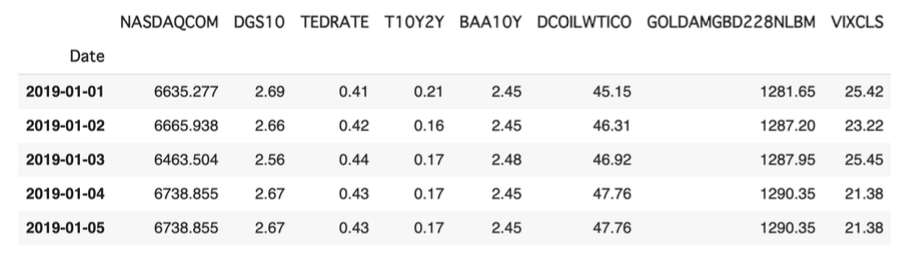

* **'NASDAQCOM'** : NASDAQ Composite Index, which is a major USA technology equity market index.

* **'DGS10'** : 10-Year Treasury Constant Maturity Rate. Interest rate of US government bonds with 10 years of maturity is often referenced as a major reference rate as risk free rate.

* **'TEDRATE'** : TED Spread, the spread between 3-month LIBOR and Treasury bills, which indicates perceived credit risk. LIBOR is the benchmark interest rate of London’s inter-bank lending/borrowing. When credit crunch happens in the financial sector, LIBOR can increase rapidly, compared with the interest of 3 month US Treasury bills.

 (Note: While US dollar LIBOR is disclosed until 2023, it will not be used after that. We need to find an alternative index to check the credit situation in the banking sector.)

* **'T10Y2Y'** : The 10-year minus 2-year Treasury (constant maturity) yields: Positive values may imply future growth, negative values may imply economic downturns. Especially, if this figure becomes negative, it is called “inverse yield”. In many cases, within 2 years after inverse yield, economic downturns and equity market crashes happened in the past.  

* **'BAA10Y'** : Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity. It shows the corporate sector’s funding and credit circumstances. In the "risk-on" market, it decreases i.e. companies can easily issue corporate bonds with low interest rates, while in the "risk-off" market, it expands i.e. companies can feel difficulty in funding by issuing corporate bonds even with high interest rates.

* **'DCOILWTICO'** : Crude Oil Prices, West Texas Intermediate (WTI) - Cushing, Oklahoma. It is a major index of oil price. And oil price represents overall commodity price movements and global inflation. When the inflation rate goes up, oil prices tend to go up synthetically. 

* **'GOLDPMGBD228NLBM'** : Gold price. Gold also constitutes an important portion in commodity asset classes. Gold price represents the “value of physical currency”, compared with the US dollar which represents the “value of paper currency”. When the risk of an emergency (such as war) rises, the gold price tends to rise. Also, when people expect high inflation, i.e. the depreciation of paper money’s value, people tend to buy gold such that the gold price tends to rise. 

* **'VIXCLS'** : CBOE Volatility Index: VIX. VIX measures market expectation of near term volatility conveyed by stock index option prices. It shows overall market sentiment of equity market participants. When many market participants expect that the equity market can be stable in the near future, VIX stays at low range. When many market participants expect that the equity market can become unstable in the near future, VIX can go up.

### 2.Data transformation

After gathering the above data, the system does preprocessing and then implements data transformation by Principal Component Analysis (PCA).

* **Data filling:** Macro economic data is usually priced and disclosed on Monday-Friday and holiday is closed i.e., around 250 trading days annually. On the other hand, bitcoin is traded every day i.e. 365 trading days annually. To fit both data comparable, the system converts annual 250 days of trading data into annual 365 days trading data, then executes fillna to fill by previous days data if the macroeconomic data is not available.

* **Rolling % change:** Then, the system calculates 30 days rolling % changes of macroeconomic data, using the function of rollingReturnCalc(preprocessed_df,days=30). The reason for taking 30 days % change and not taking daily % change is that the daily % changes of macroeconomics data is too noisy. By taking 1 month % change of macroeconomic data, the system can capture macroeconomic sentiment in a reasonable manner for practitioners as well.

* **MinMax scalar and PCA:** Next, the system executes PCA by the function of pcaDimReduction(day, macro_pct_df). But before executing PCA, the system implements another data transformation, data normalization of MinMax scalar shown on the formula below. Data normalization intends that normalized values allow the comparison of corresponding normalized values for different datasets in a way that eliminates the effects of certain gross influences.


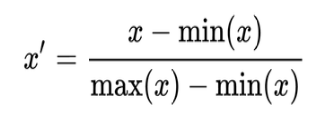

(Source: Wikipedia)

### 3.Principal Component Analysis (PCA) 

* **Principal Component Analysis (PCA)** PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. It is popularly used to reduce the dimensionality of the dataset.

* **Importance of data normalization:** As PCA is interested in the components that maximize the variance, if one component varies less than another because of their respective scales, PCA can work wrongly, such that data normalization is executed beforehand, as mentioned above.


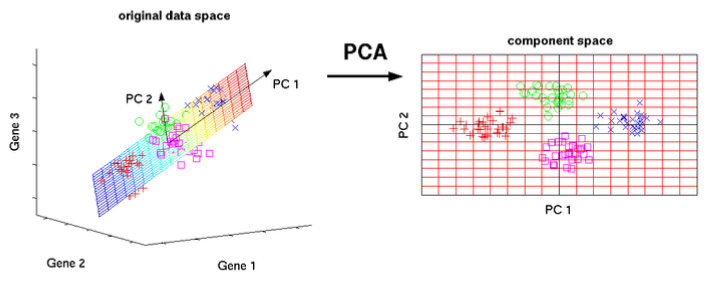

(Source:https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/)

### Final outcome

 Finally, 8 macroeconomic data can be summarized by 3 factors, shown in the following picture. Macroeconomic agent pass those data to the Decider agent, such that the Decider agent can utilize those macroeconomic data to capture the market circumstance for the day and reflect this insight when the system implements case based reasoning (CBR) as I will explain later.

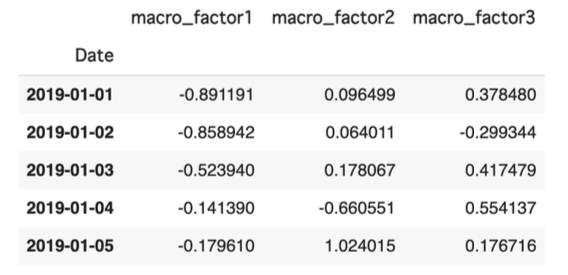

### Code of the agent

In [ ]:
class macroEconomist(object):

  @staticmethod
  def dataPreprocessing(macrodata_df):
    #data preprocessing
    startday = macrodata_df.index[0]
    endday =  macrodata_df.index[-1]

    #Change data from 250 trading days per year excluding holidays to 365 days data.
    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    #Add saturday and sunday.
    macrodata_df = macrodata_df.reset_index()
    macrodata_df = date_df.merge(macrodata_df, on='Date', how='outer')
    #change datetype of Date
    macrodata_df['Date'] = macrodata_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    macrodata_df = macrodata_df.fillna(method='ffill')
    #set Date as index.
    macrodata_df = macrodata_df.set_index(['Date'])
    macrodata_df = macrodata_df[~macrodata_df.index.duplicated(keep='first')]

    return macrodata_df

  @staticmethod
  def dataAcuisitionFromDataLibrary():
    dbConnection = sqlEngine.connect()
    macro_allhist_df = pd.read_sql("select * from MacroEconomicsData", dbConnection).set_index('Date') 
    dbConnection.close()
    macroEconomist.allhist_preprocessed_df = macroEconomist.dataPreprocessing(macro_allhist_df)

  @staticmethod
  def dataExtraction(startday, endday):
    if startday == endday:
      return macroEconomist.allhist_preprocessed_df.loc[startday,:].to_frame().T
    else:
      return macroEconomist.allhist_preprocessed_df.loc[startday:endday,:]

  @staticmethod
  def rollingReturnCalc(preprocessed_df,days=30):
    #Calculating rolling return of 1 month
    macro_pct_df = preprocessed_df.pct_change(days)
    macro_pct_df = macro_pct_df.replace([np.inf, -np.inf], 0.0)
    #Eliminating rows with nan
    macro_pct_df = macro_pct_df.dropna(thresh=3, axis=0)
    #Datatype handling
    macro_pct_df = macro_pct_df.astype('float')

    return macro_pct_df

  #Dimensionality reduction using PCA.
  @staticmethod
  def pcaDimReduction(day, macro_pct_df):
    #min-max normalization for recent 1 month
    endRow = macro_pct_df.index.get_loc(day) + 1
    startRow = max(0, endRow - 30)
    applied_data_df = macro_pct_df.iloc[startRow:endRow,:]
    #applying min-max normalization
    min_max_scaler = preprocessing.MinMaxScaler()
    normalized_df = pd.DataFrame(min_max_scaler.fit_transform(applied_data_df), 
                                  columns=applied_data_df.columns, index=applied_data_df.index)

    #PCA application
    pca = PCA(n_components=3)
    pca.fit(normalized_df)
    macro_pca = pca.transform(normalized_df)

    macro_pca_df = pd.DataFrame(macro_pca)
    macro_pca_df.columns = ['macro_factor1','macro_factor2','macro_factor3']
    macro_pca_df.index = normalized_df.index
    thisday_pca_df = macro_pca_df.loc[day,:].to_frame().T

    #macroEconomist.hist_pca_df stores 3 macro factors data historically
    macroEconomist.hist_pca_df = pd.concat([macroEconomist.hist_pca_df, thisday_pca_df])
    macroEconomist.hist_pca_df.index.names = ['Date']
    macroEconomist.hist_pca_df = macroEconomist.hist_pca_df[~macroEconomist.hist_pca_df.index.duplicated(keep='first')]

  #initialization of macro data. Obtaining some past data
  @staticmethod
  def dataInitilization(day):
    
    #get whole data from data library
    macroEconomist.dataAcuisitionFromDataLibrary()

    endday = day + datetime.timedelta(days=-1)
    startday = day + datetime.timedelta(days=-60)

    #Get data for recent days
    macro_df = macroEconomist.dataExtraction(startday, endday)
    macro_df.index = macro_df.index.rename('Date')

    #data preprocessing/cleaning
    preprocessed_df = macroEconomist.dataPreprocessing(macro_df)
    macroEconomist.hist_data_df = preprocessed_df
    macroEconomist.hist_pca_df = pd.DataFrame()

  #prepare long-term historical macro economic data
  @staticmethod
  def backtestPrep(startday,endday):
    #get whole data from data library
    macroEconomist.dataAcuisitionFromDataLibrary()

    macro_df = macroEconomist.dataExtraction(startday, endday)
    macro_df.index = macro_df.index.rename('Date')

    #data preprocessing/cleaning
    preprocessed_df = macroEconomist.dataPreprocessing(macro_df)

    
    try:
      macroEconomist.hist_data_df = pd.concat([macroEconomist.hist_data_df,
                                              preprocessed_df])
    except:
      print("please initialize macro data, using macroEconomist.dataInitilization(day)")
    
    macroEconomist.hist_data_df = macroEconomist.hist_data_df[~macroEconomist.hist_data_df.index.duplicated(keep='first')]
    macro_pct_df = macroEconomist.rollingReturnCalc(macroEconomist.hist_data_df)

    day = startday
    while day < endday + datetime.timedelta(days=1):
      macroEconomist.pcaDimReduction(day, macro_pct_df)    
      day = day + datetime.timedelta(days=1)

  #update daily macro economic data
  @staticmethod
  def dailyDataUpdate(day):

    try:
      #Get data
      daily_macro_df = macroEconomist.dataExtraction(day, day)
    except:
      #if data is not available, just return last available day
      daily_macro_df = macroEconomist.allhist_preprocessed_df.loc[:day,:].iloc[-1,:].to_frame().T

    #sometimes no data is returned. In case, just return last available day
    if len(daily_macro_df) == 0:
      daily_macro_df = pd.DataFrame(data=[[np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan]],
                          columns = daily_macro_df.columns)
      daily_macro_df = daily_macro_df.rename(index={0:day})

    daily_macro_df.index = daily_macro_df.index.rename('Date')

    #data preprocessing/cleaning
    #macroEconomist.hist_data_df stores raw macro historical data
    macroEconomist.hist_data_df = pd.concat([macroEconomist.hist_data_df,daily_macro_df])
    macroEconomist.hist_data_df = macroEconomist.dataPreprocessing(macroEconomist.hist_data_df)
    #To avoid error, confirm there is no duplicated index row 
    #by eliminating duplicated index row
    macroEconomist.hist_data_df = macroEconomist.hist_data_df[~macroEconomist.hist_data_df.index.duplicated(keep='first')]

  @staticmethod
  def dailyUpdate(day):
    macroEconomist.dailyDataUpdate(day)
    macro_pct_df = macroEconomist.rollingReturnCalc(macroEconomist.hist_data_df)
    macroEconomist.pcaDimReduction(day, macro_pct_df)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  @staticmethod
  def hist_pca_dfGetter():
    return macroEconomist.hist_pca_df

## Signal PnL and Backtesting agents

### Signal PnL Agent: PnL Recording function for each signal agent.

Signal PnL agent (in the system, class stratPnL()) is the agent to calculate profit and loss for each trading signal (i.e. SMA, Bollinger Bands, and Twitter sentiment) under certain levels of profit-taking and stop loss. For example, by receiving daily trading signals of Simple Moving Average strategy from quantitative agent, this agent calculates the PnL of a certain training and test period in the back test and daily trading activity. Below is the snapshot of the data.

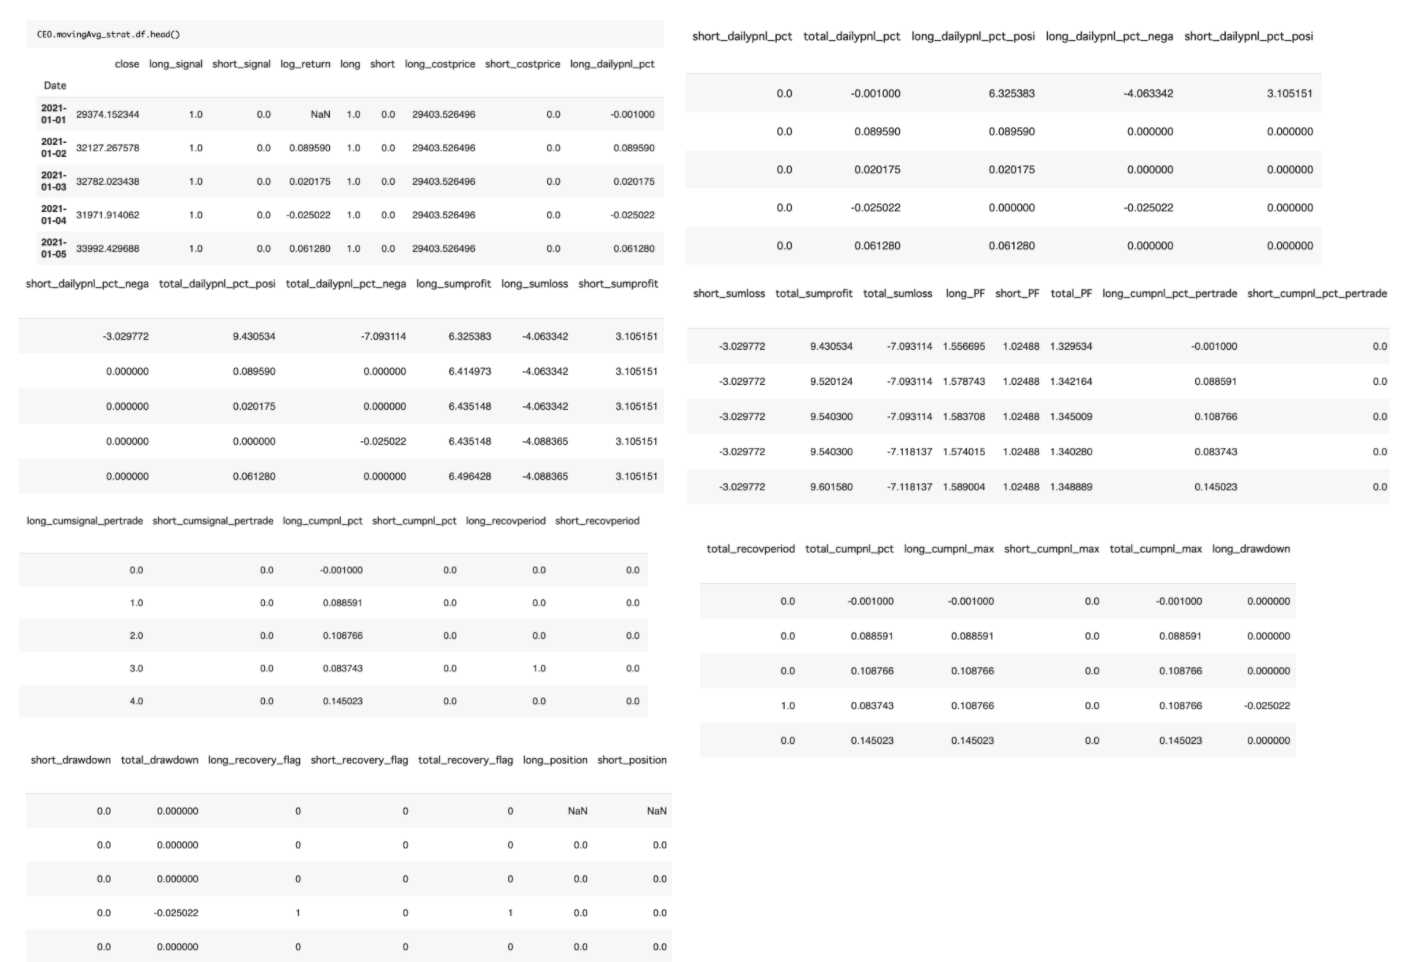

While I do not explain all columns one by one, the summary of the above PnL calculation process is shown as follows.

* First, this agent receives buy/sell signals from quantitative or qualitative agent (column long_signal and short_signal).
* When the long (short) signal turns from 0 to 1, trade starts.
* When any of the following criteria is met, trade is exited.
 - The long (short) signal moves back to 0.
 - Opposite signal arises i.e., when buying, short_signal turns from 0 to 1 and vice versa.
 - The price reaches a certain profit taking or loss cut point. (For example, if the system sets (profit_taking, loss_cut) = (0.2, 0.1), the trade is closed when the price increases by 20% from cost price or the price decreases by -10% from cost price.)

* This agent records cumulative profit of profitable trades and cumulative losses from loss-making trades. Then, this agent calculates “Profit Factor” for long position, short position, and long/short total. (Regarding the Profit Factor, I will explain it later.)

* Also, this agent records “Drawdown”, the loss from its peak performance. (Regarding the details, I will explain later.)

* Transaction cost of buying/selling is assumed as 0.1% of the price for each trade. (Regarding the notion of “transaction cost”, I will explain details later.) 


#### Profit Factor

As mentioned, stratPnL() class calculates Profit Factor (PF) of each strategy. From the definition, PF is shown as follows.


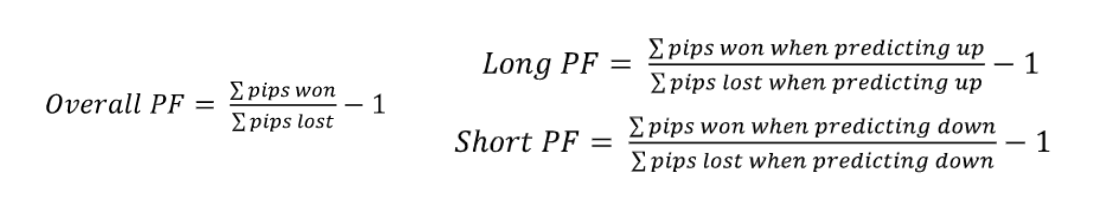

(Source: Rui Pedro Barbosa, Orlando Belo. Algorithmic Trading Using Intelligent Agents, 2008)

* However, in the actual workplace, PF is often calculated just with the gross profit divided by the gross loss (including commissions) for the entire trading period i.e. “-1” in the formula can be omitted and PF can take positive value (if profit is zero and only loss, PF=0. If there are tons of profit with very small loss, PF = very large number).

* To prevent PF taking extremely large values, the system capped PF <= 5.0.

* PF measures the profit per unit of risk, with PF >= 1.0 indicating a profitable trading strategy.

* The system utilize PF as the profitability measurement of each trading strategy (i.e. SMA, Bollinger Bands, and Twitter Sentiment), such that the system determine the weightage of how much we rely on each strategy’s recommendation at Case Based Reasoning in the Decider agent.

#### Drawdown

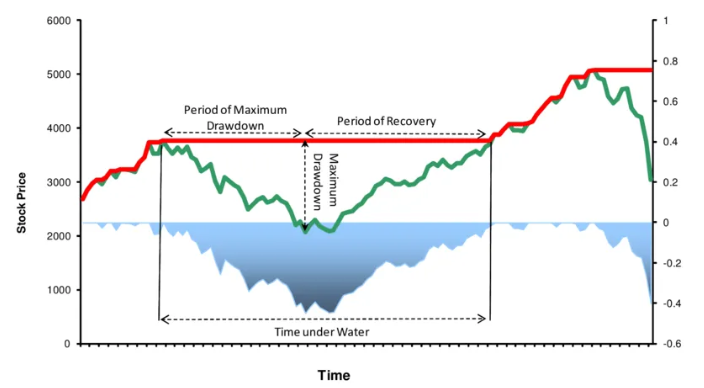

(Source: https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/maximum-drawdown/)

* In the system, stratPnL() class also calculates the “drawdown” of each strategy. 

* “Drawdown” means the amount of loss from its peak performance. 

* “Time under water” a.k.a. “Recovery period” shows total period of time from the day when the fund/strategy began to make a loss from peak, to the day when the fund/strategy could recover its loss (i.e. “going back above water”).  Of course, a shallow drawdown with fewer days of Time Under Water is better for investors, such that industry practitioners in fund industry often check those figures when they evaluate the performance of funds/trading strategies.  

* The stratPnL() class calculates those figures to visualize them into a graph.


#### Transaction cost (and its estimation)

* In the PnL calculation for each trading strategy, transaction cost is estimated as 0.1% of the closing price.

* However, formally, the “transaction cost” can be decomposed as follows:

 - Exchange fee (x)
 - Bid-Ask spread / Price (y) 
 - Market impact (MI) i.e. the cost arising from the situation where we should take a more expensive ask than best ask (when buying) and a cheaper bid than best bid (when selling) if the buy/sell amount becomes larger.
 - Opportunity cost (OC) i.e. cost regarding orders not fulfilled.


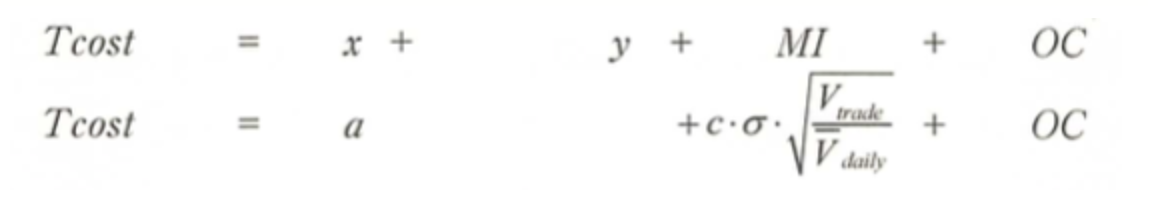

(Source: Barclays Global Investors, Fumio Nakakubo et al., Everything about quantitative active investment: its theory and practice (Written by Japanese), Kinyuu Zaisei Jijo Kenkyukai, 2008)

* However,  as a starting point of learning algorithmic trading, the above estimation sounds too complicated for most small individual investors who do not have to worry so much about market impact cost (i.e. Market Impact cost, Vtrade / Vdaily, is very close to zero for small investors), such that I just simplified the transaction cost as a fixed number of 0.1%.

* Regarding more detailed discussion, please refer final report too.

#### Code of the agent

In [ ]:
class stratPnL():
  #Function to calculate profit and loss for each trade under certain levels of profit-taking and stop loss.
  #Transaction cost includes both exchange fee and slippage i.e. the difference between the expected 
  #price of a trade and the price at which the trade is executed. More regorous sense, slippage should be 
  #calculated based on the volatility at the time, but as the initial setting, fixed amount such as 0.1% can 
  #be enough as starting point.

  #initialization of strategy PnL recording book
  def __init__(self, day,take_profit,stop_loss, transaction_cost=0.001,
               test=False, test_initial_df=None):
    
    self.test = test
    self.test_initial_df = test_initial_df
    #We set positionclose signal, current holding, cost price etc as zero.
    columns = ['close','long_signal','short_signal','log_return',
              'long','short','long_costprice','short_costprice',
                'long_dailypnl_pct','short_dailypnl_pct','total_dailypnl_pct',
                'long_dailypnl_pct_posi', 'long_dailypnl_pct_nega',
                'short_dailypnl_pct_posi','short_dailypnl_pct_nega',
                'total_dailypnl_pct_posi','total_dailypnl_pct_nega',
                'long_sumprofit','long_sumloss','short_sumprofit','short_sumloss',
                'total_sumprofit','total_sumloss',
                'long_PF','short_PF','total_PF',
                'long_cumpnl_pct_pertrade','short_cumpnl_pct_pertrade',
                'long_cumsignal_pertrade','short_cumsignal_pertrade',
                'long_cumpnl_pct','short_cumpnl_pct','long_recovperiod',
                'short_recovperiod','total_recovperiod']
    initial_data = np.zeros(len(columns))

    self.df = pd.DataFrame(data=[initial_data],columns=columns)
    self.df.index.names = ['Date']
    self.df = self.df.rename(index={0:day})

    self.take_profit = take_profit
    self.stop_loss = stop_loss
    self.transaction_cost= transaction_cost
    self.profitOrLossTaken = False

  #########################
  #long/short position
  #taking/exit
  #operation functions
  #########################

  def newLongOps(self, day):
    #long position sign = 1
    self.df.loc[day, 'long'] = 1
    #transaction cost is added to the cost price i.e. we should buy higher when we buy.
    self.df.loc[day,'long_costprice'] = self.df.loc[day, 'close'] * (1 + self.transaction_cost)
    self.df.loc[day,'long_dailypnl_pct'] = np.log(self.df.loc[day, 'close'] / self.df.loc[day, 'long_costprice'])
    #using log return, such that cumulative return is just the addition of past.
    self.df.loc[day, 'long_cumpnl_pct_pertrade'] = self.df.loc[day, 'long_dailypnl_pct']

  def newShortOps(self, day):
    self.df.loc[day,'short'] = 1
    #transaction cost is subtracted to the cost price i.e. we should sell lower when we sell.
    self.df.loc[day, 'short_costprice'] = self.df.loc[day, 'close'] * (1 - self.transaction_cost)
    self.df.loc[day, 'short_dailypnl_pct'] = np.log(self.df.loc[day, 'short_costprice'] / self.df.loc[day, 'close'])
    #using log return, such that cumulative return is just the addition of past.
    self.df.loc[day, 'short_cumpnl_pct_pertrade'] = self.df.loc[day, 'short_dailypnl_pct']

  def closeLongOps(self, day, last_day):
    #long position sign = 0
    self.df.loc[day,'long'] = 0
    #reset cost price
    self.df.loc[day,'long_costprice'] = 0
    #Calculate final trading day's performance
    self.df.loc[day,'long_dailypnl_pct'] = self.df.loc[day,'log_return'] - self.transaction_cost
    self.df.loc[day,'long_cumpnl_pct_pertrade'] = self.df.loc[last_day,'long_cumpnl_pct_pertrade']\
                                                  + self.df.loc[day,'long_dailypnl_pct']
    self.df.loc[day,'long_cumsignal_pertrade'] = self.df.loc[last_day,'long_cumsignal_pertrade'] + 1

  def closeShortOps(self, day, last_day):
    #short position sign = 0
    self.df.loc[day, 'short'] = 0
    #reset cost price
    self.df.loc[day, 'short_costprice'] = 0
    #Calculate final trading day's performance
    #It's short selling, so price going down = profit and vice versa.
    self.df.loc[day, 'short_dailypnl_pct'] = - self.df.loc[day, 'log_return'] - self.transaction_cost
    self.df.loc[day,'short_cumpnl_pct_pertrade'] = self.df.loc[last_day,'short_cumpnl_pct_pertrade'] + \
                                                    self.df.loc[day, 'short_dailypnl_pct']
    self.df.loc[day, 'short_cumsignal_pertrade'] = self.df.loc[last_day,'short_cumsignal_pertrade'] + 1

  #########################
  #daily PnL update function
  #########################

  def updateProfitLoss(self, day, signal_hist_df):

    #check last day
    last_day = day + datetime.timedelta(days=-1)
    #default value is zero, then update each figure
    self.df.loc[day,:] = np.zeros(len(self.df.columns))
    #input signal from signaling agent
    daily_signal_df = signal_hist_df.loc[day,:].to_frame().T
    self.df.loc[day,['close','long_signal','short_signal','log_return']]\
    = daily_signal_df.loc[day,['close','long_signal','short_signal','log_return']]

    #if we deal with first row, we skip some operations.
    if self.df.index.get_loc(day) == 0:
      firstRow = True
    else:
      firstRow = False

    #check yesterday's position and today's trading signal
    #then revise long position / short position owning
    if (firstRow == False) and (self.df.loc[last_day,'long'] > 0.5) and (self.df.loc[day,'long_signal'] > 0.5):
      self.df.loc[day,'long'] = 1
    if (firstRow == False) and (self.df.loc[last_day,'short'] > 0.5) and (self.df.loc[day,'short_signal'] > 0.5):
      self.df.loc[day,'short'] = 1

    #When the trading signal turns from 1 to 0, profitOrLossTaken is reset as False
    if (firstRow == False) and (self.df.loc[last_day,'long_signal'] > 0.5) and (self.df.loc[day,'long_signal'] < 0.5):
      self.profitOrLossTaken = False
    if (firstRow == False) and (self.df.loc[last_day,'short_signal'] > 0.5) and (self.df.loc[day,'short_signal'] < 0.5):
      self.profitOrLossTaken = False


    #########################
    #####New Position Taking#####
    #########################

    #When there is no position and takingposition signal arising,
    #start holding crypto position at today's market close.
    if (self.profitOrLossTaken == False) and (self.df.loc[day,'long'] < 0.5) and (self.df.loc[day,'long_signal'] > 0.5):
      
      self.newLongOps(day)
      #if short position owns, closing short position.
      if (firstRow == False) and (self.df.loc[last_day, 'short'] > 0.5):
        self.closeShortOps(day, last_day)

    #When there is no position and short signal arising,
    #start shorting crypto position at today's market close.
    elif (self.profitOrLossTaken == False) and (self.df.loc[day,'short'] < 0.5) and (self.df.loc[day,'short_signal'] > 0.5):
      
      self.newShortOps(day)
      #if long position owns, closing long position.
      if (firstRow == False) and (self.df.loc[day, 'long'] > 0.5):
        self.closeLongOps(day, last_day)

    ##################
    #Position Closing
    ##################
      
    #When position holding exists and reaching stop loss or profit taking point
    #or long_signal/short_signal = -1, position closing
    #long position
    #When position holding exists and reaching stop loss or profit taking point,
    #or long_signal/short_signal = -1, position closing.
    #long position
    elif ((firstRow == False) and (self.df.loc[last_day,'long'] > 0.5)) and \
          ((self.df.loc[last_day,'long_costprice'] * (1 + self.take_profit) < self.df.loc[day,'close']) or
           (self.df.loc[last_day,'long_costprice'] * (1 - self.stop_loss) > self.df.loc[day,'close']) or
           (self.df.loc[day,'long_signal'] < 0.5)):

            #if exiting by profit taking or loss cutting, profitOrLossTaken = True
            #to avoid entering into the market immediate again.
            if ((self.df.loc[last_day,'long_costprice'] * (1 + self.take_profit) < self.df.loc[day,'close']) or 
                (self.df.loc[last_day,'long_costprice'] * (1 - self.stop_loss) > self.df.loc[day,'close'])):

                self.profitOrLossTaken = True

            self.closeLongOps(day, last_day)

    #short position
    elif ((firstRow == False) and(self.df.loc[last_day,'short'] > 0.5)) and \
          ((self.df.loc[last_day,'short_costprice'] * (1 - self.take_profit) > self.df.loc[day,'close']) or
            (self.df.loc[last_day,'short_costprice'] * (1 + self.stop_loss) < self.df.loc[day,'close']) or
            (self.df.loc[day,'short_signal'] < -0.5)):

            #if exiting by profit taking or loss cutting, profitOrLossTaken = True
            #to avoid entering into the market immediate again.
            if ((self.df.loc[last_day,'short_costprice'] * (1 - self.take_profit) > self.df.loc[day,'close']) or 
                (self.df.loc[last_day,'short_costprice'] * (1 + self.stop_loss) < self.df.loc[day,'close'])):

                self.profitOrLossTaken = True
            
            self.closeShortOps(day, last_day)

    ########################
    #Position Continue
    ########################

    #When position holding exists and not reaching stop loss or profit taking point,
    #continue long position.
    elif  (firstRow == False) and (self.df.loc[last_day,'long'] > 0.5):

      self.df.loc[day,'long'] = self.df.loc[last_day,'long']
      self.df.loc[day,'long_costprice'] = self.df.loc[last_day,'long_costprice']
      self.df.loc[day,'long_dailypnl_pct'] = self.df.loc[day,'log_return']
      #using log return, such that cumulative return is just the addition of past.
      self.df.loc[day,'long_cumpnl_pct_pertrade'] = np.multiply([self.df.loc[day,'long_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'long_cumpnl_pct_pertrade']
                                                         + self.df.loc[day,'long_dailypnl_pct'])
      self.df.loc[day,'long_cumsignal_pertrade'] = np.multiply([self.df.loc[day,'long_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'long_cumsignal_pertrade'] + 1)

    #continue short position
    elif (firstRow == False) and (self.df.loc[last_day, 'short'] > 0.5):
      self.df.loc[day,'short'] = self.df.loc[last_day,'short']
      self.df.loc[day,'short_costprice'] = self.df.loc[last_day,'short_costprice']
      self.df.loc[day,'short_dailypnl_pct'] = - self.df.loc[day,'log_return']
      #using log return, such that cumulative return is just the addition of past.
      self.df.loc[day,'short_cumpnl_pct_pertrade'] = np.multiply([self.df.loc[day,'short_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'short_cumpnl_pct_pertrade']
                                                          + self.df.loc[day,'short_dailypnl_pct'])
      self.df.loc[day,'short_cumsignal_pertrade'] = np.multiply([self.df.loc[day,'short_dailypnl_pct'] != 0.0],
                                                        self.df.loc[last_day,'short_cumsignal_pertrade'] + 1)

    ##################
    #update for any cases
    ##################

    #Any cases, update profit factor related columns
    if self.df.loc[day,'long_dailypnl_pct'] >= 0:
      self.df.loc[day,'long_dailypnl_pct_posi'] = self.df.loc[day,'long_dailypnl_pct']
    elif self.df.loc[day,'long_dailypnl_pct'] < 0:
      self.df.loc[day,'long_dailypnl_pct_nega'] = self.df.loc[day,'long_dailypnl_pct']

    if self.df.loc[day,'short_dailypnl_pct'] >= 0:
      self.df.loc[day,'short_dailypnl_pct_posi'] = self.df.loc[day,'short_dailypnl_pct']
    elif self.df.loc[day,'short_dailypnl_pct'] < 0:
      self.df.loc[day,'short_dailypnl_pct_nega'] = self.df.loc[day,'short_dailypnl_pct']

    self.df.loc[day,'total_dailypnl_pct'] = self.df.loc[day,'long_dailypnl_pct'] + \
                                              self.df.loc[day,'short_dailypnl_pct']
    self.df.loc[day,'total_dailypnl_pct_posi'] = self.df.loc[day,'long_dailypnl_pct_posi']\
                                             + self.df.loc[day,'short_dailypnl_pct_posi']
    self.df.loc[day,'total_dailypnl_pct_nega'] = self.df.loc[day,'long_dailypnl_pct_nega']\
                                             + self.df.loc[day,'short_dailypnl_pct_nega']

    #if stratPnL calculation is regarding test data, we intake profit factor (PF)
    #related data from training data.
    if (self.test == True) and (firstRow == True):
      self.df['long_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['long_sumprofit'].iloc[-1]
      self.df['long_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['long_sumloss'].iloc[-1]
      self.df['short_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['short_sumprofit'].iloc[-1]
      self.df['short_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['short_sumloss'].iloc[-1]
      self.df['total_dailypnl_pct_posi'].iloc[0] = self.test_initial_df['total_sumprofit'].iloc[-1]
      self.df['total_dailypnl_pct_nega'].iloc[0] = self.test_initial_df['total_sumloss'].iloc[-1]

    ##################
    #calculation after daily pnl calculation
    ##################

    #Finally, calculating cumulative profit / loss by dailypnl.
    self.df['long_cumpnl_pct'] = self.df['long_dailypnl_pct'].cumsum()
    self.df['short_cumpnl_pct'] = self.df['short_dailypnl_pct'].cumsum()
    self.df['total_cumpnl_pct'] = self.df['long_cumpnl_pct'] + self.df['short_cumpnl_pct']

    #Calculating profit factor
    self.df['long_sumprofit'] = self.df['long_dailypnl_pct_posi'].cumsum()
    self.df['long_sumloss'] = self.df['long_dailypnl_pct_nega'].cumsum()
    self.df['short_sumprofit'] = self.df['short_dailypnl_pct_posi'].cumsum()
    self.df['short_sumloss'] = self.df['short_dailypnl_pct_nega'].cumsum()
    self.df['total_sumprofit'] = self.df['long_sumprofit'] + self.df['short_sumprofit']
    self.df['total_sumloss'] = self.df['long_sumloss'] + self.df['short_sumloss']

    self.df['long_PF'] = self.df['long_sumprofit']/np.abs(self.df['long_sumloss'])
    self.df['short_PF'] = self.df['short_sumprofit']/np.abs(self.df['short_sumloss'])
    self.df['total_PF'] = self.df['total_sumprofit']/np.abs(self.df['total_sumloss'])

    #truncate at 5 if loss is very small and PF is very large
    self.df['long_PF'] = self.df['long_PF'].apply(lambda x: 5 if x > 5 else x)
    self.df['short_PF'] = self.df['short_PF'].apply(lambda x: 5 if x > 5 else x)
    self.df['total_PF'] = self.df['total_PF'].apply(lambda x: 5 if x > 5 else x)
    #fill nan
    self.df['long_PF'] = self.df['long_PF'].fillna(0)
    self.df['short_PF'] = self.df['short_PF'].fillna(0)
    self.df['total_PF'] = self.df['total_PF'].fillna(0)

    #Calculating drawdown by cumulative profit / loss
    self.df['long_cumpnl_max'] = self.df['long_cumpnl_pct'].cummax()
    self.df['short_cumpnl_max'] = self.df['short_cumpnl_pct'].cummax()
    self.df['total_cumpnl_max'] = self.df['total_cumpnl_pct'].cummax()

    self.df['long_drawdown'] = self.df['long_cumpnl_pct'] - self.df['long_cumpnl_max']
    self.df['short_drawdown'] = self.df['short_cumpnl_pct'] - self.df['short_cumpnl_max']
    self.df['total_drawdown'] = self.df['total_cumpnl_pct'] - self.df['total_cumpnl_max']

    #Calculating recovery period
    self.df['long_recovery_flag'] = self.df['long_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    self.df['short_recovery_flag'] = self.df['short_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    self.df['total_recovery_flag'] = self.df['total_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)

    if firstRow == False:
      self.df.loc[day,'long_recovperiod'] = np.multiply([self.df.loc[day,'long_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'long_recovperiod'] + 1)
      self.df.loc[day,'short_recovperiod'] = np.multiply([self.df.loc[day,'short_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'short_recovperiod'] + 1)
      self.df.loc[day,'total_recovperiod'] = np.multiply([self.df.loc[day,'total_recovery_flag'] != 0.0],
                                                        self.df.loc[last_day,'total_recovperiod'] + 1)

    #Add long/short position difference to capture start/close date of each position.
    self.df['long_position'] = self.df['long'].diff()
    self.df['short_position'] = self.df['short'].diff()

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def dfGetter(self):
    return self.df

### Back-testing agent with sliding train/test split

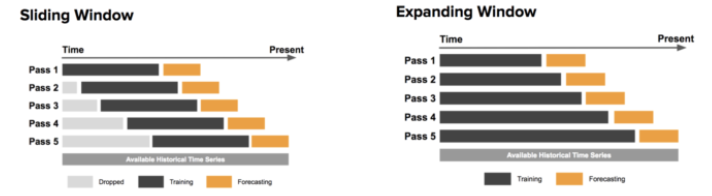

(Source: https://stackoverflow.com/questions/56601488/is-there-a-way-to-get-a-sliding-nested-cross-validation-using-sklearn)

* Then, to implement back-test correctly, we need to implement the "Sliding Window" (aka "Work Forward") shown in the above picture. The system implemented it at class backTest(object).

* **Training data:** By training data, we optimize the parameters of strategy (For example, in SMA, day combination of short-term moving average and long-term moving average) to obtain best return.

* **Test data:** Then, in the test or forecasting period, we check whether an optimized strategy can work in an out-of-sample period. 

* By doing so, we can avoid overfitting to past data and can check whether this strategy can work in the future. Train/test split using sliding windows is important to do back-test and build machine learning models for time-series data. With regard to how to slide train/split windows, there are 2 ways.

 - **Sliding window:** One is the sliding window, shown on the left hand side of the picture below. In this case, both training periods are fixed (i.e. training period: 2 years, test period: 1 year, for example). Then, we slide train/test period.
 - **Expanding window:** The other is the expanding window, shown on the right hand side of the picture below. In this case, the training period spans from the starting time until immediate before the test period. It means that the period of training data becomes longer and longer, as we test recent data.

* While some quants' finance books suggest the expanding window, many industry practitioners and quantitative finance literature apply the sliding window as industry standard. We followed industry standards by applying the sliding window in the system.

#### Parameter optimization by sharpe ratio

Next, we should determine the criteria for the parameter optimization.

* **Maximize return?:** One way is just to maximize the return in the training period. For example, we can choose the combination of short-term moving average days and long-term moving average days (like short-term MA = 10 day, long-term MA = 20 days), the combination by which we can maximize the return in the training period and apply those parameters into the test period. 

* **Taking account risk -> Sharpe Ratio:** However, it is not the industry standard. When we consider the return, we also take into account how much we take the risk to obtain this return. In this context, Sharpe Ratio is popularly used in the financial industry to evaluate the performance of certain trading strategies or funds, shown as follows. In the system, def generateBenchmarkComp(df, annualtradedays=365) in class backTest(object) calculates it.

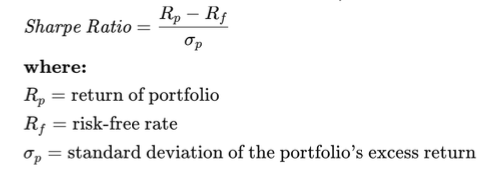

(Source: https://www.investopedia.com/terms/s/sharperatio.asp)

There are some tips and industry customs when we calculate Sharpe ratio.

* **Annual return:** Usually, Rp is stated as an annual return. Just summing up the daily log returns for 1 years, it can become the annual return.

* **Annual volatility:** Also, σp is stated as an annual volatility. By converting daily volatility based on daily % changes into annual volatility, the formula is σ_annual = σ_day*sqrt(trading days for 1 year i.e. 365 in bitcoin's case). When it comes to equity which we do not trade Saturday/Sunday and national holiday, usually 250 days are used i.e. σ_annual = σ_day*sqrt(250).

* **Treatment of Rf:** Risk-free rate can be often omitted and σp can be just calculated as the portfolio’s volatility (not the volatility of the portfolio’s excess return, i.e. σ(Rp - Rf)) in industry custom, because nowadays the risk free rate tends to be low and because the calculation of Rp / σp can be just simpler. By following such industry custom, the system calculates the Sharpe Ratio of trading strategy as Rp / σp, by omitting Rf.

The system optimizes parameters of each strategy to maximize the annualized Sharpe Ratio by greedy search. For example, in SMA strategy, the system tries (short-term MA, long-term MA) = (5,10),(5,20),(10,20) and calculates the sharpe ratio by using each (short-term MA, long-term MA) under training data period. Then, the system applies the parameter with best performance at train data into test data.

#### Multi threading

While it is a technical matter, I introduced multi-threading at the implementation of **def
backtestWithSlidingWindow(start,end)** in **class backTest(object)**. By multithreading, the system is able to process multiple threads of codes or functions concurrently.

In algorithmic trading, there can be the situation when we need to run multiple agents together, especially if the data time-horizon becomes shorter than a day, i.e. trading with 5 minutes of price tick data. In such a situation, we can utilize multithreading.

**Note:** Under the Python environment, the system operates each thread just with a single core CPU by switching between threads. So, multithreading by Python may not contribute to the faster operation. Rather, it can become slower due to the additional tasks of switching operations among the working threads. If we would like to implement very short term trading by using minute ticks or shorter, such operational speed can become the issue and we may need to implement the algorithm by Java (faster than Python, but slower than C++) or C++ (faster than Python and Java, but the complexity of implementation can rise and there may not be so much available engineers who can write C++). In the area of HFT (High Frequency Trading) in which the algorithmic system trades equities just by microseconds, mainly C++ or FPGA are used.

#### Code of the agent

In [ ]:
class backTest(object):

  #train_size: # of each training dataset, test_size: # of each test dataset.
  #Due to rounding of n_splits calculation and for loop logic below, 
  #actual output size of training dataset and test dataset can be slightly different
  #from train_size and test_size.
  @staticmethod
  def sliding_window(df, train_size, test_size):

    df = df.copy()

    #Calculate n_aplits by the length of dataframe / test_size.
    n_splits = math.floor(len(df) / test_size)
    #Utilize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    #Blank list for storing train/test splits.
    splits = []
    for train_index, test_index in tscv.split(df):
      #if the # of data of train_index <= train_size, just storing this train, test split.
      if len(train_index) <= train_size:
          continue
      #if train_index > train_size, truncate data to the train_size.
      else:
          train_index = train_index[-train_size:]
      #store train/test split to the list.
      splits.append([train_index, test_index])

    return splits

  @staticmethod
  def sliding_day_acquisition(splits, df):
    train_test_days = []
    for i in range(0,len(splits)):
      train_test_days.append([df.index[splits[i][0]],df.index[splits[i][1]]])

    return train_test_days

  #calculate and summerize sharpe ratio and buy-and-hold return comparison 
  #from each strategy's pnl dataframe 
  @staticmethod
  def generateBenchmarkComp(df, annualtradedays=365):

    df = df.copy()

    ###domain knowledge###
    #annualtradedays : please input annual trading days. For crypto, it can trade 24/7 and 
    #365 days annually, so input 365. For equity and other asset classes which can be 
    #traded only on Mon.-Fri. excluding public holiday, industry custum is to input 250 days.

    #As a fund industry custum, return, volatility, and sharpe ratio are calculated and 
    #compared based on annualized return and volatility.

    #Market return, volatility, and sharpe ratio
    num_trading_days = len(df)
    market_total_ret = df['log_return'].sum()
    market_annual_avgret = market_total_ret / (num_trading_days/annualtradedays)
    market_volatility = df['log_return'].std()
    market_annualized_volatility = market_volatility * np.sqrt(annualtradedays)
    market_sharpe_ratio = market_annual_avgret / market_annualized_volatility

    #long return, volatility, and sharpe ratio
    long_total_ret = df['long_cumpnl_pct'].iloc[-1]
    long_annual_avgret = long_total_ret / (num_trading_days/annualtradedays)
    long_volatility = df['long_dailypnl_pct'].std()
    long_annualized_volatility = long_volatility * np.sqrt(annualtradedays)
    long_sharpe_ratio = long_annual_avgret / long_annualized_volatility

    #short return, volatility, and sharpe ratio
    short_total_ret = df['short_cumpnl_pct'].iloc[-1]
    short_annual_avgret = short_total_ret / (num_trading_days/annualtradedays)
    short_volatility = df['short_dailypnl_pct'].std()
    short_annualized_volatility = short_volatility * np.sqrt(annualtradedays)
    short_sharpe_ratio = short_annual_avgret / short_annualized_volatility

    #total trading, i.e. both long and short, return, volatility, and sharpe ratio
    total_total_ret = df['total_cumpnl_pct'].iloc[-1]
    total_annual_avgret = total_total_ret / (num_trading_days/annualtradedays)
    total_volatility = df['total_dailypnl_pct'].std()
    total_annualized_volatility = total_volatility * np.sqrt(annualtradedays)
    total_sharpe_ratio = total_annual_avgret / total_annualized_volatility

    return_dict = {'market_total_ret': market_total_ret,
                  'market_annual_ret': market_annual_avgret,
                  'market_annual_volatility': market_annualized_volatility,
                  'market_sharpe_ratio': market_sharpe_ratio,
                  'long_total_ret': long_total_ret,
                  'long_annual_ret': long_annual_avgret,
                  'long_annual_volatility': long_annualized_volatility,
                  'long_sharpe_ratio': long_sharpe_ratio,
                  'short_total_ret': short_total_ret,
                  'short_annual_ret': short_annual_avgret,
                  'short_annual_volatility': short_annualized_volatility,
                  'short_sharpe_ratio': short_sharpe_ratio,
                  'total_total_ret': total_total_ret,
                  'total_annual_ret': total_annual_avgret,
                  'total_annual_volatility': total_annualized_volatility,
                  'total_sharpe_ratio': total_sharpe_ratio
                  }

    return return_dict

  ##################
  #training data's optimization tool
  ##################

  #Optimizing parameters of moving average at training data.
  @staticmethod
  def movingAvgOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #technical indicator
    ########################

    #parameters for moving average
    ma_list = [5,10,20]
    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of moving average, we implement back-testing.
    #i.e. (st_ma,lt_ma) = (5,10),(5,20),(10,20)
    for (shortMA,longMA) in itertools.combinations(ma_list,2):
      #instantiation of quantsSignal classes
      quantSignal_backtest = quantsSignal(backtest=True)

      for day in train_days_list:
        quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)
      
      agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
      day0 = agent1_hist_signal_df.index[0]
      #we set take_profit and stop_loss level. (999,999) means no
      #profit take / loss cut by performance.
      strat_optim =  stratPnL(day0, 999, 999)

      for day in agent1_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [shortMA, longMA]
        maxsharpe_profitloss = [999,999]
        maxsharpe_agent1_hist_signal_df = agent1_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  without setting profit-taking/losscut: {}"\
            .format(shortMA, longMA, sharpe))

    ########################
    #optimizing profit taking/loss cut level
    ########################

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent1_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent1_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent1_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of moving average [shortMA,longMA] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  #Optimize parameters of bollinger band at training data.
  @staticmethod
  def bollingerOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #technical indicator
    ########################

    #Optimizing parameter list: bollinger band
    datawindow_list = [10,20]
    stddev_list = [2.0, 3.0]

    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of parameters, we implement back-testing.
    for (datawindow,stddev) in itertools.product(datawindow_list,stddev_list):

      #instantiation of quantsSignal
      quantSignal_backtest = quantsSignal(backtest=True)

      for day in train_days_list:
        quantSignal_backtest.bollingerDailyUpdate(day,datawindow,stddev)
      
      agent2_hist_signal_df = quantSignal_backtest.agent2SignalGetter()
      day0 = agent2_hist_signal_df.index[0]
      #we set take_profit and stop_loss level
      strat_optim =  stratPnL(day0, 999, 999)

      for day in agent2_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent2_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']
      print("sharpe ratio of bollinger with MA {} and std {}  without setting profit-taking/losscut: {}"\
            .format(datawindow, stddev, sharpe))

      #check whether it's the best ever or not
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [datawindow, stddev]
        maxsharpe_profitloss = [999,999]
        maxsharpe_agent2_hist_signal_df = agent2_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

    ########################
    #optimizing profit taking/loss cut level
    ########################

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent2_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent2_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent2_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of bollinger [datawindow,stddev] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  #Optimize parameters of twitter signal at training data.
  @staticmethod
  def twitterOptimization(train_days_list):

    ########################
    #optimizing parameters related with
    #twitter sentiment
    ########################

    #Optimizing parameter list
    buy_level_list = [40, 45]
    sell_level_list = [20, 25]

    #for storing sharpe ratio. starting from very low figure,
    #such that new results are updated for optimization
    maxsharpe = -9999
    maxsharpe_combination = [0, 0]
    maxsharpe_df = pd.DataFrame()

    #For each combination of parameters, we implement back-testing.
    for (buy_lev, sell_lev) in itertools.product(buy_level_list, sell_level_list):

      #instantiation of twitterSignal classes
      twitterSignal_backtest = twitterSignal(train_days_list[0], backtest=True)

      for day in train_days_list:
        #data window is fixed as 5 day (caz it takes long time)
        twitterSignal_backtest.dailyUpdate(day,5,buy_lev,sell_lev)
      
      agent3_hist_signal_df = twitterSignal_backtest.agent3SignalGetter()
      day0 = agent3_hist_signal_df.index[0]
      #we set take_profit and stop_loss level
      strat_optim =  stratPnL(day0, 999, 999)

      for day in agent3_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, agent3_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']
      print("sharpe ratio of twitter, buying at {}, and selling at {} without setting profit-taking/losscut: {}"\
      .format(buy_lev, sell_lev, sharpe))

      #check whether it's the best ever or not
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_combination = [buy_lev, sell_lev]
        maxsharpe_profitloss = [999,999]
        maxsharpe_agent3_hist_signal_df = agent3_hist_signal_df
        maxsharpe_df = strat_optim.dfGetter()

    #After optimizing shortMA and longMA parameters,
    #for each combination of take_profit, stop_loss, we implement back-testing

    tradeexit_list = [0.1,0.2]

    for (take_profit, stop_loss) in itertools.product(tradeexit_list,repeat=2):

      day0 = maxsharpe_agent3_hist_signal_df.index[0]
      #we set take_profit and stop_loss level.
      strat_optim =  stratPnL(day0, take_profit, stop_loss)

      for day in maxsharpe_agent3_hist_signal_df.index:
        strat_optim.updateProfitLoss(day, maxsharpe_agent3_hist_signal_df)

      #check sharpe ratio
      sharpe = backTest.generateBenchmarkComp(strat_optim.dfGetter())['total_sharpe_ratio']

      #check moving avg
      if sharpe > maxsharpe:
        maxsharpe = sharpe
        maxsharpe_profitloss = [take_profit, stop_loss]
        maxsharpe_df = strat_optim.dfGetter()

      print("sharpe ratio of twitter [buy_level,sell_level] = [{},{}]  with [profiting, losscut] = [{},{}]: {}"\
            .format(maxsharpe_combination[0], maxsharpe_combination[1], take_profit, stop_loss, sharpe))

    output = [maxsharpe_combination, maxsharpe_profitloss, maxsharpe_df]
    return output

  @staticmethod
  def movingAvgTest(movingAvg_list, test_days_list):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    shortMA = movingAvg_list[0][0]
    longMA = movingAvg_list[0][1]
    profit_taking = movingAvg_list[1][0]
    loss_cut = movingAvg_list[1][1]
                              
    for day in test_days_list:
      quantSignal_backtest.movingAvgDailyUpdate(day,shortMA,longMA)

    agent1_hist_signal_df = quantSignal_backtest.agent1SignalGetter()
    day0 = agent1_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=movingAvg_list[2])

    for day in agent1_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent1_hist_signal_df)

    backTest.movingAvgTestResult = strat_optim.dfGetter()

  @staticmethod
  def bollingerTest(bollinger_list, test_days_list):
    #instantiation of quantsSignal classes
    quantSignal_backtest = quantsSignal(backtest=True)

    datawindow = bollinger_list[0][0]
    stddev = bollinger_list[0][1]
    profit_taking = bollinger_list[1][0]
    loss_cut = bollinger_list[1][1]
                              
    for day in test_days_list:
      quantSignal_backtest.bollingerDailyUpdate(day,datawindow,stddev)

    agent2_hist_signal_df = quantSignal_backtest.agent2SignalGetter()
    day0 = agent2_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=bollinger_list[2])

    for day in agent2_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent2_hist_signal_df)

    backTest.bollingerTestResult = strat_optim.dfGetter()

  @staticmethod
  def twitterTest(twitter_list, test_days_list):
    #instantiation of twitterSignal classes
    twitterSignal_backtest = twitterSignal(test_days_list[0], backtest=True)

    buy_level = twitter_list[0][0]
    sell_level = twitter_list[0][1]
    profit_taking = twitter_list[1][0]
    loss_cut = twitter_list[1][1]
                              
    for day in test_days_list:
      twitterSignal_backtest.dailyUpdate(day,5,buy_level,sell_level)

    agent3_hist_signal_df = twitterSignal_backtest.agent3SignalGetter()
    day0 = agent3_hist_signal_df.index[0]
    #we set take_profit and stop_loss level from training data
    strat_optim =  stratPnL(day0, profit_taking, loss_cut, test=True, test_initial_df=twitter_list[2])

    for day in agent3_hist_signal_df.index:
      strat_optim.updateProfitLoss(day, agent3_hist_signal_df)

    backTest.twitterTestResult = strat_optim.dfGetter()

  ####################
  #Whole back-testing process
  #with sliding window
  ####################

  #Function for the re-calculation of cumulative return, drawdown etc
  #After concatenating whole test period results
  @staticmethod
  def reCalculateAfterBackTest(final_outcome_df):
    #Finally, recalculating cumulative profit / loss by dailypnl.
    final_outcome_df['long_cumpnl_pct'] = final_outcome_df['long_dailypnl_pct'].cumsum()
    final_outcome_df['short_cumpnl_pct'] = final_outcome_df['short_dailypnl_pct'].cumsum()
    final_outcome_df['total_cumpnl_pct'] = final_outcome_df['total_dailypnl_pct'].cumsum()

    #recalculating daily pnl for long/short total
    final_outcome_df['total_dailypnl_pct'] = final_outcome_df['long_dailypnl_pct'] + final_outcome_df['short_dailypnl_pct']

    #recalculating drawdown by cumulative profit / loss
    final_outcome_df['long_cumpnl_max'] = final_outcome_df['long_cumpnl_pct'].cummax()
    final_outcome_df['short_cumpnl_max'] = final_outcome_df['short_cumpnl_pct'].cummax()
    final_outcome_df['total_cumpnl_max'] = final_outcome_df['total_cumpnl_pct'].cummax()

    final_outcome_df['long_drawdown'] = final_outcome_df['long_cumpnl_pct'] - final_outcome_df['long_cumpnl_max']
    final_outcome_df['short_drawdown'] = final_outcome_df['short_cumpnl_pct'] - final_outcome_df['short_cumpnl_max']
    final_outcome_df['total_drawdown'] = final_outcome_df['total_cumpnl_pct'] - final_outcome_df['total_cumpnl_max']

    #Calculating recovery period
    final_outcome_df['long_recovery_flag'] = final_outcome_df['long_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    final_outcome_df['short_recovery_flag'] = final_outcome_df['short_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)
    final_outcome_df['total_recovery_flag'] = final_outcome_df['total_drawdown'].apply(lambda x: 1 if x < 0.0 else 0)

    for ind in range(1,len(final_outcome_df)):
      final_outcome_df['long_recovperiod'][ind] = np.multiply([final_outcome_df['long_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['long_recovperiod'][ind-1] + 1)
      final_outcome_df['short_recovperiod'][ind] = np.multiply([final_outcome_df['short_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['short_recovperiod'][ind-1] + 1)
      final_outcome_df['total_recovperiod'][ind] = np.multiply([final_outcome_df['total_recovery_flag'][ind] != 0.0],
                                                        final_outcome_df['total_recovperiod'][ind-1] + 1)

    #Add long/short position difference to capture start/close date of each position.
    final_outcome_df['long_position'] = final_outcome_df['long'].diff()
    final_outcome_df['short_position'] = final_outcome_df['short'].diff()

    return final_outcome_df

  @staticmethod
  def backtestWithSlidingWindow(start,end):

    #obtain long BTC historical data (2014-2020), then split into train (2 years)
    #and test (1 year) with sliding window
    backtestdata_df = Broker.longHistoryPriceGetter().loc[start:end,:]
    splits = backTest.sliding_window(backtestdata_df, 730, 365)
    train_test_days = backTest.sliding_day_acquisition(splits,Broker.longHistoryPriceGetter())

    #With all sliding windows, implementing optimization at training data 
    #-> taking performance at test data based on optimized parameters
    
    movingAvg_test_finallist = []
    bollinger_test_finallist = []
    twitter_test_finallist = []

    for num_sliding_window in range(len(train_test_days)):

      #obtain train day / test day
      train_days = train_test_days[num_sliding_window][0]
      test_days = train_test_days[num_sliding_window][1]

      #optimization of training data
      opt_movingAvg_list = backTest.movingAvgOptimization(train_days)
      opt_bollinger_list = backTest.bollingerOptimization(train_days)
      opt_twitter_list = backTest.twitterOptimization(train_days)

      #test by test data, using optimized parameters at training data
      thread1 = threading.Thread(target=backTest.movingAvgTest, args=(opt_movingAvg_list, test_days))
      thread2 = threading.Thread(target=backTest.bollingerTest, args=(opt_bollinger_list, test_days))
      thread3 = threading.Thread(target=backTest.twitterTest, args=(opt_twitter_list, test_days))

      thread1.start()
      thread2.start()
      thread3.start()

      thread1.join()
      thread2.join()
      thread3.join()

      #results of training data with optimized parameters
      #and save those as csv files
      movingAvg_trainresult_df = opt_movingAvg_list[2]
      bollinger_trainresult_df = opt_bollinger_list[2]
      twitter_trainresult_df = opt_twitter_list[2]

      movingAvg_trainresult_filename = "movingAvg_trainresult_df_{}.csv".format(num_sliding_window)
      bollinger_trainresult_filename = "bollinger_trainresult_df_{}.csv".format(num_sliding_window)
      twitter_trainresult_filename = "twitter_trainresult_df_{}.csv".format(num_sliding_window)

      #It takes very long time, so save as csv file
      movingAvg_trainresult_df.to_csv('backtest_testresult_data/' + movingAvg_trainresult_filename)
      bollinger_trainresult_df.to_csv('backtest_testresult_data/' + bollinger_trainresult_filename)
      twitter_trainresult_df.to_csv('backtest_testresult_data/' + twitter_trainresult_filename)

      movingAvg_testresult_filename = "movingAvg_testresult_df_{}.csv".format(num_sliding_window)
      bollinger_testresult_filename = "bollinger_testresult_df_{}.csv".format(num_sliding_window)
      twitter_testresult_filename = "twitter_testresult_df_{}.csv".format(num_sliding_window)

      backTest.movingAvgTestResult.to_csv('backtest_testresult_data/' + movingAvg_testresult_filename)
      backTest.bollingerTestResult.to_csv('backtest_testresult_data/' + bollinger_testresult_filename)
      backTest.twitterTestResult.to_csv('backtest_testresult_data/' + twitter_testresult_filename)

      if num_sliding_window == 0:

        #results of test data based on optimized parameters
        movingAvg_testresult_df = backTest.movingAvgTestResult
        bollinger_testresult_df = backTest.bollingerTestResult
        twitter_testresult_df = backTest.twitterTestResult
      else:
        movingAvg_testresult_df = pd.concat([movingAvg_testresult_df,backTest.movingAvgTestResult])
        bollinger_testresult_df = pd.concat([bollinger_testresult_df,backTest.bollingerTestResult])
        twitter_testresult_df = pd.concat([twitter_testresult_df,backTest.twitterTestResult])

    ############################
    #after calculating whole test result,
    #we should re-calculate cumulative return, drawdown etc
    ############################
    #re-calculation of cumulative return, drawdown etc
    movingAvg_testresult_df = backTest.reCalculateAfterBackTest(movingAvg_testresult_df)
    bollinger_testresult_df = backTest.reCalculateAfterBackTest(bollinger_testresult_df)
    twitter_testresult_df = backTest.reCalculateAfterBackTest(twitter_testresult_df)

    #It takes very long time, so save as csv file
    movingAvg_testresult_df.to_csv('backtest_testresult_data/movingAvg_testresult_all_df.csv')
    bollinger_testresult_df.to_csv('backtest_testresult_data/bollinger_testresult_all_df.csv')
    twitter_testresult_df.to_csv('backtest_testresult_data/twitter_testresult_all_df.csv')

  #last 2 years of training
  @staticmethod
  def tradingPrepTraining(start, end):
    final_train_days = Broker.longHistoryPriceGetter().loc[start:end,:].index
    #optimization of training data
    opt_movingAvg_list = backTest.movingAvgOptimization(final_train_days)
    opt_bollinger_list = backTest.bollingerOptimization(final_train_days)
    opt_twitter_list = backTest.twitterOptimization(final_train_days)

    final_training_list = [opt_movingAvg_list,opt_bollinger_list,opt_twitter_list]

    return final_training_list

  #data visualization
  @staticmethod
  def allTestPerformanceGraph(strat_df):

    df = strat_df.copy()

    #set figsize as (10,10)
    fig = plt.figure(figsize=(10,10))
    #set ax for price (larger window) and volume (smaller window)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

    #plotting closing price, bollinger high band and low band
    ax1.plot(df.index,'close', color='k', data=df)
    # plot buy signals
    ax1.plot(df[df['long_position'] > 0.5].index, 
            df['close'][df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax1.plot(df[df['short_position'] > 0.5].index, 
            df['close'][df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax1.legend()
    ax1.set_title('Test data performance', fontsize=20)
    ax1.set_ylabel('Price', fontsize = 15 )
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt2 = ax1.twinx()
    plt2.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt2.plot(df.index,'long_cumpnl_pct', color = 'r', data=df)
    plt2.plot(df.index,'short_cumpnl_pct', color = 'b', data=df)
    plt2.plot(df.index,'total_cumpnl_pct', color = 'g',lw=5, data=df)
    plt2.legend(loc=4)

    ax2.plot(df.index, 'long_drawdown', color = 'r', data=df)
    ax2.plot(df.index, 'short_drawdown', color = 'b', data=df)
    ax2.plot(df.index, 'total_drawdown', color = 'g',lw=5, data=df)
    ax2.set_title('Drawdown by long, short, total', fontsize=20)
    ax2.legend(loc=4)

    fig.tight_layout()
    plt.show()
  
  @staticmethod
  def trainTestperformanceGraph(train_df, test_df):

    train_df = train_df.copy()
    test_df = test_df.copy()
    #set figsize
    fig = plt.figure(figsize=(15,10))
    #set ax for price (larger window) and volume (smaller window)
    ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
    #set ax for price (larger window) and volume (smaller window)
    ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 2), (2, 1), rowspan=1)

    ##########
    #train data
    ##########

    #plotting closing price, bollinger high band and low band
    ax1.plot(train_df.index,'close', color='k', data=train_df)
    # plot buy signals
    ax1.plot(train_df[train_df['long_position'] > 0.5].index, 
            train_df['close'][train_df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax1.plot(train_df[train_df['short_position'] > 0.5].index, 
            train_df['close'][train_df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax1.legend()
    ax1.set_title('Train data performance', fontsize=20)
    ax1.set_ylabel('Price', fontsize = 10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt2 = ax1.twinx()
    plt2.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt2.plot(train_df.index,'long_cumpnl_pct', color = 'r', data=train_df)
    plt2.plot(train_df.index,'short_cumpnl_pct', color = 'b', data=train_df)
    plt2.plot(train_df.index,'total_cumpnl_pct', color = 'g',lw=5, data=train_df)
    plt2.legend(loc=4)

    ax2.plot(train_df.index, 'long_drawdown', color = 'r', data=train_df)
    ax2.plot(train_df.index, 'short_drawdown', color = 'b', data=train_df)
    ax2.plot(train_df.index, 'total_drawdown', color = 'g',lw=5, data=train_df)
    ax2.set_title('Drawdown by long, short, total', fontsize=20)
    ax2.legend(loc=4)

    ##########
    #test data
    ##########

    #plotting closing price, bollinger high band and low band
    ax3.plot(test_df.index,'close', color='k', data=test_df)
    # plot buy signals
    ax3.plot(test_df[test_df['long_position'] > 0.5].index, 
            test_df['close'][test_df['long_position'] > 0.5], 
            '^', markersize = 10, color = 'r', label = 'long')
    # plot sell signals
    ax3.plot(test_df[test_df['short_position'] > 0.5].index, 
            test_df['close'][test_df['short_position'] > 0.5], 
            '^', markersize = 10, color = 'b', label = 'short')
    ax3.legend()
    ax3.set_title('Test data performance', fontsize=20)
    ax3.set_ylabel('Price', fontsize = 15 )
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

    #right axis for cumulative profit
    plt4 = ax3.twinx()
    plt4.set_ylabel('Cum. Profit (added %)', fontsize = 15 )
    plt4.plot(test_df.index,'long_cumpnl_pct', color = 'r', data=test_df)
    plt4.plot(test_df.index,'short_cumpnl_pct', color = 'b', data=test_df)
    plt4.plot(test_df.index,'total_cumpnl_pct', color = 'g', lw=5,data=test_df)
    plt4.legend(loc=4)

    ax4.plot(test_df.index, 'long_drawdown', color = 'r', data=test_df)
    ax4.plot(test_df.index, 'short_drawdown', color = 'b', data=test_df)
    ax4.plot(test_df.index, 'total_drawdown', color = 'g', lw=5, data=test_df)
    ax4.set_title('Drawdown by long, short, total', fontsize=20)
    ax4.legend(loc=4)

    fig.tight_layout()
    plt.show()

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

In [ ]:
#####################
#Sliding window and performance of test data
#It takes 1-2 hours.
#I've already saved past performance for reference.
#####################

#start = datetime.datetime(2014,1,1)
#end = datetime.datetime(2020,12,31)
#backTest.backtestWithSlidingWindow(start,end)

### Summary of strategies, each traing and test period

* Below are the examples of performance in the training period and test period with 4 sets of sliding windows for the SMA strategy.

* **Train/test split:** Former 2 years of data is used as a training period to optimize parameters of short term moving average and long term moving average. Also, with the optimized parameters, the last 1 year is traded as a test period.

* **Sliding window:** Then, the system slides a dataset of 2 years of training data and 1 year of test data, by 1 year ahead.

* **Result:** As you can see, in the training data period on the left hand side of the graph, the performance is great i.e. total cumulative profit of the green line goes upward in a constant manner because it is the performance with the optimized parameters after try-and-errors by greedy search. However, in the test data period on the right hand side, the performance is not as great as was in the training data period.

* **Traders' dilemma...Overfitting:** Such result shows typical reality in algorithmic trading. Many traders optimize the parameter by past data such that the back-testing performance i.e. training data’s performance looks great. However, in reality, when we apply the optimized parameter into future data for real trading, the performance cannot be as good as was in the test data. It is a popular phenomena called “overfitting” toward training data. Many trading systems just show great performance in the training data period, but most of them cannot be reproducible in the real trading for the future coming data.

* **Where is holy grail?:** Searching for the robust trading model which shows constant performance in the both training and test period can be the important theme for the quantitative researchers, while it is very challenging.

##### SMA strategy

In [ ]:
for i in range(0,4):
  movingAvg_trainresult_df = pd.read_csv('backtest_testresult_data/movingAvg_trainresult_df_{}.csv'.format(i))
  movingAvg_trainresult_df = movingAvg_trainresult_df.set_index('Date')
  movingAvg_trainresult_df.index = pd.to_datetime(movingAvg_trainresult_df.index)

  movingAvg_testresult_df = pd.read_csv('backtest_testresult_data/movingAvg_testresult_df_{}.csv'.format(i))
  movingAvg_testresult_df = movingAvg_testresult_df.set_index('Date')
  movingAvg_testresult_df.index = pd.to_datetime(movingAvg_testresult_df.index)

  backTest.trainTestperformanceGraph(movingAvg_trainresult_df, movingAvg_testresult_df)

FileNotFoundError: ignored

##### Bollinger Bands strategy

In [ ]:
for i in range(0,4):
  bollinger_trainresult_df = pd.read_csv('backtest_testresult_data/bollinger_trainresult_df_{}.csv'.format(i))
  bollinger_trainresult_df = bollinger_trainresult_df.set_index('Date')
  bollinger_trainresult_df.index = pd.to_datetime(bollinger_trainresult_df.index)

  bollinger_testresult_df = pd.read_csv('backtest_testresult_data/bollinger_testresult_df_{}.csv'.format(i))
  bollinger_testresult_df = bollinger_testresult_df.set_index('Date')
  bollinger_testresult_df.index = pd.to_datetime(bollinger_testresult_df.index)

  backTest.trainTestperformanceGraph(bollinger_trainresult_df, bollinger_testresult_df)

##### Twitter sentiment strategy

In [ ]:
for i in range(0,4):
  twitter_trainresult_df = pd.read_csv('backtest_testresult_data/twitter_trainresult_df_{}.csv'.format(i))
  twitter_trainresult_df = twitter_trainresult_df.set_index('Date')
  twitter_trainresult_df.index = pd.to_datetime(twitter_trainresult_df.index)

  twitter_testresult_df = pd.read_csv('backtest_testresult_data/twitter_testresult_df_{}.csv'.format(i))
  twitter_testresult_df = twitter_testresult_df.set_index('Date')
  twitter_testresult_df.index = pd.to_datetime(twitter_testresult_df.index)

  backTest.trainTestperformanceGraph(twitter_trainresult_df, twitter_testresult_df)

### Performance by strategies, connected by 4 test periods

In [ ]:
movingAvg_testresult_df = pd.read_csv('backtest_testresult_data/movingAvg_testresult_all_df.csv')
movingAvg_testresult_df = movingAvg_testresult_df.set_index('Date')
movingAvg_testresult_df.index = pd.to_datetime(movingAvg_testresult_df.index)
bollinger_testresult_df = pd.read_csv('backtest_testresult_data/bollinger_testresult_all_df.csv')
bollinger_testresult_df = bollinger_testresult_df.set_index('Date')
bollinger_testresult_df.index = pd.to_datetime(bollinger_testresult_df.index)
twitter_testresult_df = pd.read_csv('backtest_testresult_data/twitter_testresult_all_df.csv')
twitter_testresult_df = twitter_testresult_df.set_index('Date')
twitter_testresult_df.index = pd.to_datetime(twitter_testresult_df.index)

##### SMA strategy: Test data only

In [ ]:
backTest.allTestPerformanceGraph(movingAvg_testresult_df)

##### Bollinger Bands:Test data only

In [ ]:
backTest.allTestPerformanceGraph(bollinger_testresult_df)

##### Twitter sentiment strategy:Test data only

In [ ]:
backTest.allTestPerformanceGraph(twitter_testresult_df)

## Decider agent

### 1.Overall function

* The decider agent receives daily buy/sell trading signals from quantitative agent (SMA and Bollinger Bands) and qualitative agent (Twitter sentiment strategy).

* Also, the decider agent receives daily 3 macroeconomic factor data calculated by the macro economist agent. Then, the decider creates the final recommendation based on signaling agents, macro economic factors, and CBR's case retrieval.

* Finally, the CEO agent will receive the final recommendation from the decider agent to take final action.

### 2.Logic of combining buy/sell decisions from 3 different agents

First, the Decider agent receives buy/sell recommendations of SMA, Bollinger Bands, and Twitter sentiment from quantitative and qualitative agents. To merge different trading signals into one final recommendation, I defined the following formula.

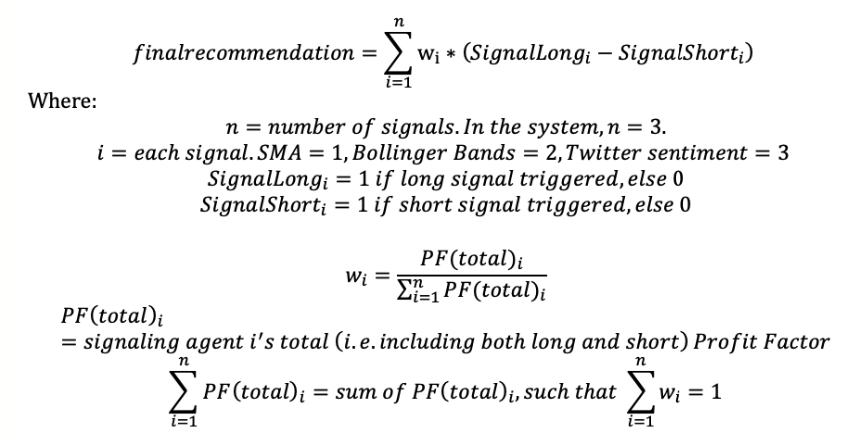

* Final recommendation is the weighted average of (SignalLong - SignalShort), in terms of the weight w calculated by the Profit Factor, which is calculated at the section of Signal PnL and Backtesting agents. 

* Above equation looks scary, but it just means that, if the Profit Factor from a certain agent is high, the weightage of this trading strategy becomes high.

 For example, in a certain day...
 
 - SMA agent has PF=2.0 (very profitable)
 - Bollinger Bands has PF=1.0 (zero profit or loss)
 - Twitter sentiment has PF=0.5 (loss is larger than profit)
 
 In this case, weightages are shown as follows:
 
 - Weightage of SMA = 2.0 / (2.0+1.0+0.5) = 0.5714
 - Weightage of Bollinger Bands = 1.0 / (2.0+1.0+0.5) = 0.2857
 - Weightage of Twitter sentiment = 0.5 / (2.0+1.0+0.5) = 0.1428
 
 Below charts shows the example of the movements for PF and weights regarding each agent (agent1=SMA, agent2=Bollinger Bands, agent3=Twitter sentiment).

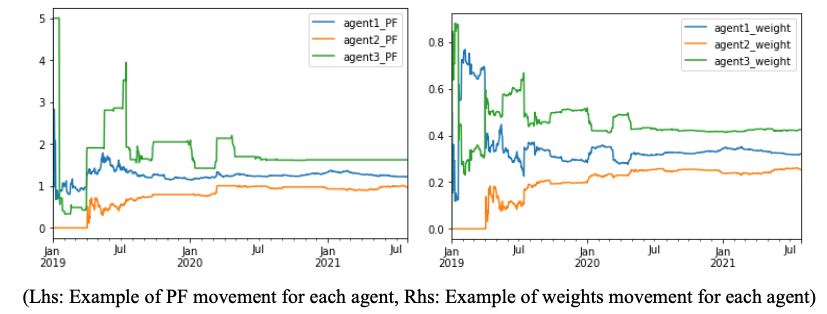

* And today, for example, if SMA shows buy, Bollinger Band shows neutral (both buy/sell signals are 0), and Twitter sentiment shows sell, then the finalrecommendation can become as follows:

 finalrecommendation = 0.5714*(1 - 0) + 0.2857*(0 - 0) + 0.1428*( 0 - 1)
 = 0.5714 + 0 - 0.1428 = 0.4286
 
* As you can infer, when all trading signals show buy recommendation, finalrecommendation is equal to 1.0, while when all trading signals show sell recommendation, finalrecommendation is equal to -1.0. Also, when all signals are neutral, finalrecommendation = 0.0.

* Then, the system convert “finalrecommendation” into 5 (strong buy), 4 (buy), 3 (neutral), 2 (sell), and 1 (strong sell) with following criteria. In above example of 0.4286, it becomes Buy (4) rating:
 - finalrecommendation > 0.5: Strong buy 5
 - 0.1 < finalrecommendation <= 0.5: Buy 4
 - 0.1 < finalrecommendation <= 0.1: Neutral 3
 - -0.5 < finalrecommendation <= -0.1: Sell 2
 - finalrecommendation <= -0.5: Strong sell 1

* Below chart shows the trading decisions made by the Decider, which reflects PF and weights for each agent shown in previous charts.

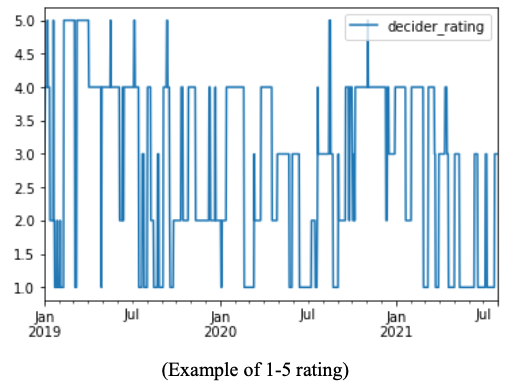

* Those calculations are implemented at the functions of def receiveSignal(agent1_hist, agent2_hist, agent3_hist),def mergeSignal(agent1_hist, agent2_hist, agent3_hist),def recommendationConverter(x), and def deciderRecommendation(allsignals_df)
in class cbrDecider(object).

### 3.Case Based Reasoning (CBR)

In the previous section, we could calculate the “final recommendation” by integrating 3 signals from SMA, Bollinger Bands, Twitter Sentiment.

However, so far, we are not sure whether the certain day’s signaling combination (e.g. SMA=buy, Bollinger=neutral, Twitter=sell in previous example) showed great performance after the day (let’s say, t+1 to t+10 days from certain day t).

Also, the performance can depend on the macroeconomic environment at a certain day t. To confirm such points, the system then applies Case Based Reasoning (CBR), with adding 3 macroeconomic factors data obtained by macro economist agent.

CBR is a relatively mature methodology in the Artificial Intelligence domain. The roots of case-based reasoning in AI is found in the works of Roger Schank and his students such as Janet Kolondner at Yale University in the early 1980s . In the 1990s, interest in CBR grew internationally, as evidenced by the establishment of an International Conference on Case-Based Reasoning in 1995.

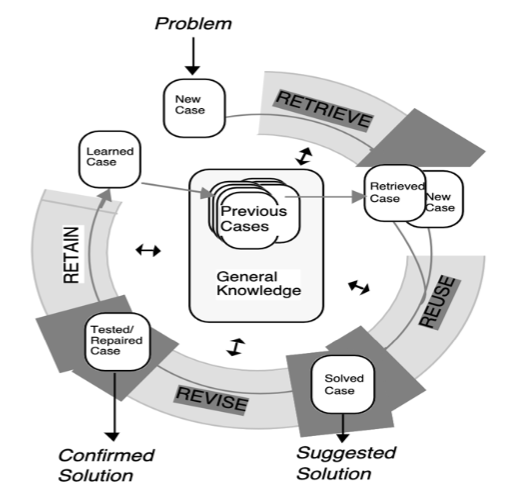

(Source: Aamodt Agnar, Enric Plaza.Case-Based Reasoning, Foundational Issues Methodological Variations and System Approaches, 1994)

Central tasks of CBR are to deal with identifying the current problem situation, finding past cases similar to the new one (Retrieve), using those similar cases to suggest a solution to the current problem (Reuse), evaluating the proposed solution (Revise), and updating the system by learning from this experience (Retain).

In the financial market, searching for “past similar market circumstances with today” to find some insights for the future is a natural way of thinking for many market practitioners. The purpose of CBR application toward algorithmic trading is to mimic such market practitioners’ methodology.

### 4.k-Nearest Neighbors (kNN)

To implement the case retrieval in CBR system, k-nearest neighbour (kNN) algorithm and its advanced application with the further improvement and/or the combination with other algorithms such as genetic algorithm (GA) are widely used. To illustrate how kNN works in the context of CBR, I implemented simple kNN this time in the system.

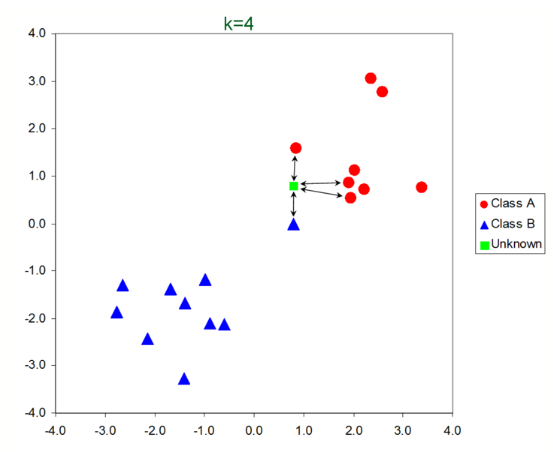

(Source:http://scholarpedia.org/article/K-nearest_neighbor) 

* K Nearest Neighbours (kNN) is the algorithm to take the distance among certain feature vectors and extract top kth nearest vectors in terms of distances.

* For example, in the above picture, k = 4, and 3 data from the red circle and 1 data from blue are taken for the new coming data of green.

* With regard to taking distance, the Minkowski distance below is popular. Especially, when we take q=2, it becomes Euclidean distance and this is popularly used in the kNN algorithm.

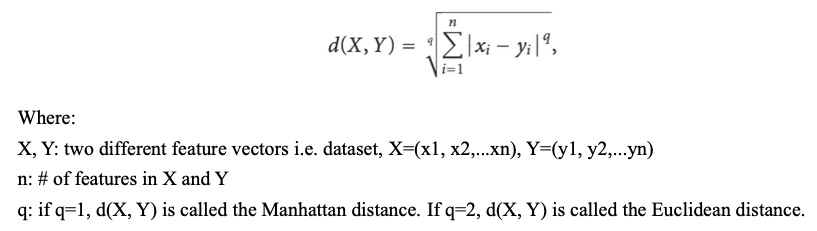

(Reference: Xiaoyuan Su and Taghi M Khoshgoftaar. A survey of collaborative filtering techniques, 2009)

* **Curse of dimensionality:** You can take note that the kNN performs better with a lower number of features. If the number of features increases, it requires more data to perform kNN appropriately. Increase in dimension of the
feature vector can also lead to the problem of overfitting. We call such problems, which is due to the higher dimension, the “Curse of dimensionality”. 

* **Reason to use PCA before kNN:** To avoid the curse of dimensionality, we often use PCA to reduce the dimensionality of data, as shown in Macro Economist agent.

### 5.Implementation of Case Retrieval in CBR by kNN

* We can apply kNN to implement the CBR of cryptocurrency trading in the same manner. In the above mentioned graph, green unknown data corresponds to today's newly coming market data. Then, the system can search k nearest past market data that correspond to red circles and blue triangulars. By doing so, the system can implement the “Retrieve” section of CBR.

* In our system, data shown below picture is stored in the past case data storage (i.e. dataframe of cbrDecider.case_data_df), and we can extract the top 30 (i.e. k=30) of the most similar datasets compared with the certain day, by using kNN.

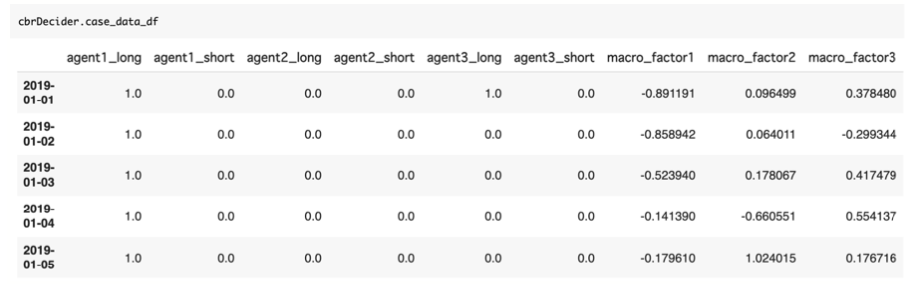

* As a result, the CBR system can obtain the data of “the most similar past market condition” in terms of the buy/sell recommendation from 3 signaling agents and the macroeconomic environment summarized by 3 macroeconomic factors. 

* To avoid the curse of dimensionality mentioned above, macroeconomic data is summarized into 3 factors, using PCA in the previous section.

* Usually, the performance of kNN can improve by the dimensionality reduction using PCA (or other methodologies of dimensionality reduction of data), such that you can utilize the combination of PCA => kNN as one of your tools in your arsenal when you implement data analytics including but not limited to the financial market data analysis.

### 6.Logic of Case Reuse, Revise, and Retain part in CBR

Next, I will show how the system implements the “Reuse” part of CBR. Whole above process is implemented at the function of def dailyReportToCEO(day, k=30, shreshold_p = 0.05) in the class cbrDecider(object).

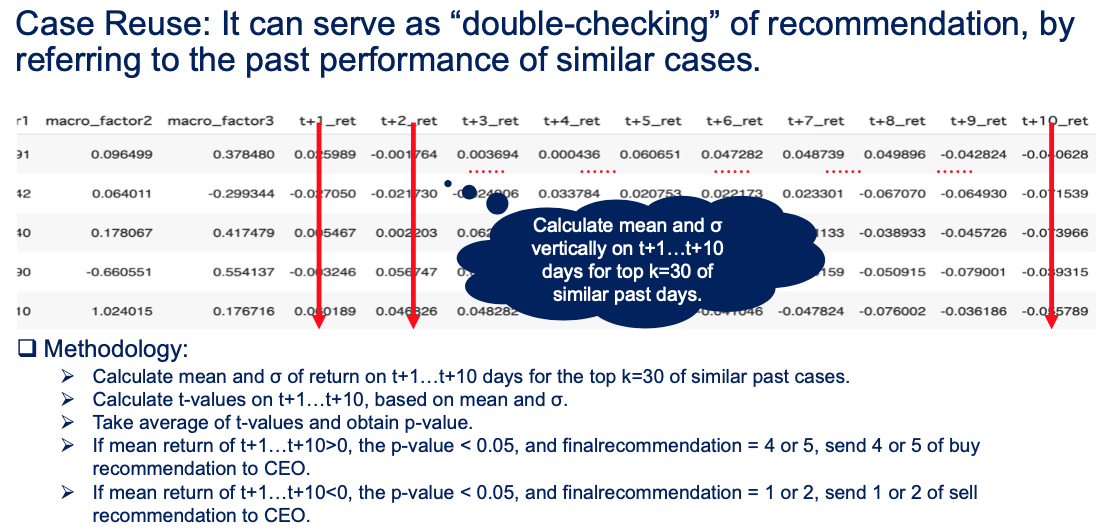

Above process means that the CBR of Reuse part can serve as the “double checking” function to confirm whether the recommendation can fit to the past actual performance in terms of the past similar cases.

After the Decider sends this double-checked recommendation to the CEO agent, the Decider agent updates the past case as of today to execute the “Revise” and “Retain” part in CBR. By doing so, new cases are updated daily such that the Decider can utilize recent cases for the next day. The function of **def caseUpdate(day)** in the **class cbrDecider(object)** is the implementation of those parts.

### Code of the agent

In [ ]:
class cbrDecider(object):

  ###################
  #Basic functions
  ###################

  #receiving signals from each signaling agent
  @staticmethod
  def receiveSignal(agent1_hist, agent2_hist, agent3_hist):
    
    signals_df_list = [agent1_hist, agent2_hist, agent3_hist]

    #extract only relevant information for decider, from each agent
    for i in range(len(signals_df_list)):
      signals_df_list[i] = signals_df_list[i][['long','short','total_PF']]
      long_column_name = 'agent' + str(i+1) + '_long'
      short_column_name = 'agent' + str(i+1) + '_short'
      PF_column_name = 'agent' + str(i+1) + '_PF'

      signals_df_list[i].columns = [long_column_name,short_column_name,
                                    PF_column_name]
    return signals_df_list

  @staticmethod
  def mergeSignal(agent1_hist, agent2_hist, agent3_hist):
    signals_df_list = cbrDecider.receiveSignal(agent1_hist, agent2_hist, agent3_hist)
    #then, merge each agents' signaling into 1 dataframe    
    allsignals_df = pd.DataFrame()
    allsignals_df = signals_df_list[0]
    for j in range(1, len(signals_df_list)):
      allsignals_df = allsignals_df.merge(signals_df_list[j], left_index=True,
                                          right_index=True, how='inner')
    
    #calculate the sum of profit factors, then calculate weight of each signals by
    #following formula:
    #weight of signal A = profit factor of signal A / sum of profit factors for all signals.
    allsignals_df['sum_PF'] = 0
    for k in range(1, len(signals_df_list)+1):
      allsignals_df['sum_PF'] = allsignals_df['sum_PF'] + allsignals_df['agent' + str(k) + '_PF']

    for m in range(1, len(signals_df_list)+1):
      #(to avoid error, adding + 0.0000000001 at denominator)
      allsignals_df['agent' + str(m) + '_weight'] = allsignals_df['agent' + str(m) + '_PF'] / \
                                                    (allsignals_df['sum_PF'] + 0.0000000001)

    #calculate the final score (-1 to 1, -1:strong sell recommendation, +1:strong buy
    #recommendation) for final decision to report CEO agent by weighted average of each signals
    allsignals_df['final_score'] = 0
    for n in range(1, len(signals_df_list)+1):
      allsignals_df['final_score'] = allsignals_df['final_score'] \
                                      + allsignals_df['agent' + str(n) + '_weight'] * allsignals_df['agent' + str(n) +'_long'] \
                                      + allsignals_df['agent' + str(n) + '_weight'] * - allsignals_df['agent' + str(n) +'_short']
    
    return allsignals_df

  #return final recommendation from 1:strong sell to 5:strong buy
  #-0.5 - -1= 1 strong sell
  #-0.1 - -0.5 = 2 sell
  #-0.1 - +0.1 = 3 neutral
  #+0.1 - +0.5 = 4 buy
  #+0.5 - +1.0 = 5 strong buy
  @staticmethod
  def recommendationConverter(x):
    if x > 0.5:
      return 5
    elif x > 0.1:
      return 4
    elif x > -0.1:
      return 3
    elif x > -0.5:
      return 2
    elif x >= -1.0:
      return 1

  #convert each agent's recommendation -> final_score into decider's recommendation
  @staticmethod
  def deciderRecommendation(allsignals_df):
    allsignals_df['decider_rating'] = allsignals_df['final_score']\
                                      .apply(cbrDecider.recommendationConverter)
    
    return allsignals_df

  #storing t+1...t+10 return of crypto on each days i.e. t+0
  #We store t+1...t+10 crypto prices for CBR's case at deciderCBR.coin_price_df
  @staticmethod
  def caseInitialization(day, training = False):

    tMinus1day = day + datetime.timedelta(days=-1)
    #price data acquisition
    coin_price_df = Broker.longHistoryPriceGetter().loc[:tMinus1day,:]

    #compute return of 1day,2days...10days. 
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df['close'].pct_change(i)

    #shifting upward by 1 day for t+1, 2 days for t+2...10 days for t+10.
    #By doing so, t+1...t+10 columns become future t+i days' return as of t+0 day.
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df[column_name].shift(-i)
    
    #Eliminating rows with nan
    #We store t+1...t+10 crypto prices for CBR's case at deciderCBR.coin_price_df
    coin_price_df = coin_price_df.dropna(axis=0)

    return coin_price_df

  #after updating deciderCBR.coin_price_df, decider.allsignals_df, macroEconomist.hist_pca_df,
  #unifying those data to update CBR's case data, deciderCBR.case_data_df
  @staticmethod
  def caseIntegration(coin_price_df, allsignals_df, hist_pca_df):
    coin_price_df = coin_price_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                              't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                              't+9_ret','t+10_ret']]
    allsignals_df = allsignals_df.loc[:,['agent1_long','agent1_short',
                                          'agent2_long','agent2_short',
                                          'agent3_long','agent3_short']]
    hist_pca_df = hist_pca_df

    case_data_df = allsignals_df.merge(hist_pca_df,left_index=True,right_index=True)
    #store case data into deciderCBR.case_data_df
    case_data_df = case_data_df.merge(coin_price_df,left_index=True,right_index=True)

    return case_data_df

  ###################
  #Initialization
  #When we start trading, we run it
  ###################

  #initialization of decider
  @staticmethod
  def deciderInitialization(final_training_list, day):
    #creating signal history dataframe
    cbrDecider.signal_to_ceo_hist_df = pd.DataFrame()
    #obtain cases from training data
    agent1_hist_df = final_training_list[0][2]
    agent2_hist_df = final_training_list[1][2]
    agent3_hist_df = final_training_list[2][2]
    allsignals_df = cbrDecider.mergeSignal(agent1_hist_df, agent2_hist_df, agent3_hist_df)
    #storing signaling information into cbrDecider.allsignals_df
    cbrDecider.allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)
    #initialize coin_price_df (crypto return of t+1...t+10 from t+0)
    cbrDecider.coin_price_df = cbrDecider.caseInitialization(day, training = True)
    #training period's macro data, which should be initialized before this operation
    tMinus1 = day + datetime.timedelta(days=-1)
    cbrDecider.hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[:tMinus1,:]
    #case_data_df is the integration of above
    case_data_df = cbrDecider.caseIntegration(cbrDecider.coin_price_df, 
                                              cbrDecider.allsignals_df, 
                                              cbrDecider.hist_pca_df)
    #storing past case data at training period to cbrDecider.case_data_df
    cbrDecider.case_data_df = case_data_df

  ###################
  #Daily update
  ###################

  #Update tool of deciderCBR.coin_price_df
  #update this day = day's t+1...t+10 ret. It can be updated until 10 days ago
  @staticmethod
  def dailyCasePriceUpdate(day):
    tMinus10_day = day + datetime.timedelta(days=-10)

    #relevant price data acquisition
    coin_price_df = Broker.longHistoryPriceGetter().loc[tMinus10_day:day,:]

    #compute return of 1day,2days...10days. 
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df['close'].pct_change(i)

    #shifting upward by 1 day for t+1, 2 days for t+2...10 days for t+10.
    #By doing so, t+1...t+10 columns become future t+i days' return as of t+0 day.
    for i in range(1,11):
      column_name = 't+' + str(i) + '_ret'
      coin_price_df[column_name] = coin_price_df[column_name].shift(-i)
    
    #Eliminating rows with nan
    coin_price_df = coin_price_df.dropna(axis=0)

    #update new data and store it onto cbrDecider.coin_price_df
    cbrDecider.coin_price_df = pd.concat([cbrDecider.coin_price_df, coin_price_df])

  #Update tool of deciderCBR.allsignals_df
  #We should update agent1_hist, agent2_hist, agent3_hist by quantitative / twitter agents
  #and put those into this function
  @staticmethod
  def updateSignals(day, agent1_hist, agent2_hist, agent3_hist):
    allsignals_df = cbrDecider.mergeSignal(agent1_hist, agent2_hist, agent3_hist)
    allsignals_df = cbrDecider.deciderRecommendation(allsignals_df)
    allsignals_df = allsignals_df.loc[day,:].to_frame().T

    #update new data and store it onto cbrDecider.allsignals_df
    cbrDecider.allsignals_df = pd.concat([cbrDecider.allsignals_df, allsignals_df])

  #Update macro economic data, cbrDecider.hist_pca_df
  #We should update macroEconomist.hist_pca_df, before running it
  @staticmethod
  def updateMacro(day):
    hist_pca_df = macroEconomist.hist_pca_dfGetter().loc[day,:].to_frame().T
    cbrDecider.hist_pca_df = pd.concat([cbrDecider.hist_pca_df, hist_pca_df])

  @staticmethod
  def updateNewCaseData(day):
    #store case data into deciderCBR.signal_macro_df
    cbrDecider.signal_macro_df = cbrDecider.allsignals_df.merge(cbrDecider.hist_pca_df,
                                                                left_index=True,right_index=True)

  #Case retrieval using kNN
  @staticmethod
  def dailyReportToCEO(day, k=30, shreshold_p = 0.05):

    #obtain stored case data
    train_sig_ret_df = cbrDecider.case_data_df
    #new data
    newsignal_df = cbrDecider.signal_macro_df.loc[day,:].to_frame().T
    newsignal_for_knn_df = newsignal_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                 'agent2_short','agent3_long','agent3_short',
                                 'macro_factor1','macro_factor2','macro_factor3']]

    #create empty dataframe to send signal_to_ceo
    signal_to_ceo_df = pd.DataFrame(index=newsignal_df.index)
    signal_to_ceo_df['report_ceo'] = 0

    #Fit NearestNeighbors
    model = NearestNeighbors(algorithm = "brute")
    #pick up agentX_long,agentX_short, macro_factorX columns
    model_col = train_sig_ret_df.loc[:,['agent1_long','agent1_short','agent2_long',
                                 'agent2_short','agent3_long','agent3_short',
                                 'macro_factor1','macro_factor2','macro_factor3']]
    #train kNN model
    fitted = model.fit(model_col)

    ########################
    #coming new data, and find
    #k-nearest cases using kNN
    ########################

    #To each test days, we extract similar k past cases (so, using "k"-NN).
    #distance is euclidean distance (the smaller, the closer to test data)
    #indice is the set of list of past similar cases in training data.
    distance, indice = fitted.kneighbors(newsignal_for_knn_df,
                                         n_neighbors=k)
    
    #extract top k days in training data
    #we extract "same or very similar recommendation combination among 3 different
    #signaling agent with similar macro 3 factor figures".
    #Extracting same recommendation at similar macro/market circumstance is reasonable
    #to refer as past case for future decision.
    case_top_k_days_df = train_sig_ret_df.iloc[indice[0],:]
    #extract t+1 - t+10 performance of bitcoin for each similar cases from training data.
    case_top_k_days_df = case_top_k_days_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                          't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                          't+9_ret','t+10_ret']]
    #calculate mean, std, and t-value for t+1 - t+10
    topk_ret_mean = case_top_k_days_df.mean(axis=0)
    topk_ret_std = case_top_k_days_df.std(axis=0)
    topk_ret_tval = topk_ret_mean / (topk_ret_std/np.sqrt(len(case_top_k_days_df)))

    #mean return and t-value of future t+1 - t+10
    mean_ret = topk_ret_mean.mean()
    mean_tvalue = topk_ret_tval.mean()
    #mean p-value from mean t-value
    mean_p = st.t.sf(abs(mean_tvalue), len(case_top_k_days_df)-1)

    decider_rating = newsignal_df['decider_rating'].values[0]

    #Final decision
    #if decider rating, mean_ret, mean_p shows "buy", send 4 buy or 5 strong buy 
    #to CEO.
    if ((decider_rating > 3.5) and (mean_ret > 0.0) and (mean_p < shreshold_p)):
      signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
    #if decider rating, mean_ret, mean_p shows "sell", send 2 sell or 1 strong sell 
    #to CEO.
    elif ((decider_rating < 2.5) and (mean_ret < 0.0) and (mean_p < shreshold_p)):
      signal_to_ceo_df['report_ceo'].loc[day] = decider_rating
    #else (i.e. decider_rating = 3, decider_rating and mean_ret are contradictionary,
    #or p-value > shreshold_p), just send 3=neutral to CEO agent.
    else:
      signal_to_ceo_df['report_ceo'].loc[day] = 3
    
    #update and store cbrDecider.signal_to_ceo_hist_df
    if len(cbrDecider.signal_to_ceo_hist_df) == 0:
      cbrDecider.signal_to_ceo_hist_df = signal_to_ceo_df
    else:
      cbrDecider.signal_to_ceo_hist_df = pd.concat([cbrDecider.signal_to_ceo_hist_df,
                                                    signal_to_ceo_df])
      cbrDecider.signal_to_ceo_hist_df['report_ceo_diff'] = cbrDecider.signal_to_ceo_hist_df['report_ceo'].diff()

  #new case update
  @staticmethod
  def caseUpdate(day):
    tMinus10 = day + datetime.timedelta(days=-10)
    coin_price_df = cbrDecider.coin_price_df.loc[:,['t+1_ret','t+2_ret','t+3_ret','t+4_ret',
                                              't+5_ret','t+6_ret','t+7_ret','t+8_ret',
                                              't+9_ret','t+10_ret']]
    allsignals_df = cbrDecider.allsignals_df.loc[:,['agent1_long','agent1_short',
                                          'agent2_long','agent2_short',
                                          'agent3_long','agent3_short']]
    hist_pca_df = cbrDecider.hist_pca_df

    case_data_df = allsignals_df.merge(hist_pca_df,left_index=True,right_index=True)
    case_data_df = case_data_df.merge(coin_price_df,left_index=True,right_index=True)
    case_data_today_df = case_data_df.loc[tMinus10,:].to_frame().T

    cbrDecider.case_data_df = pd.concat([cbrDecider.case_data_df, case_data_today_df])

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  @staticmethod
  def allSignalsGetter():
    return cbrDecider.allsignals_df

  @staticmethod
  def caseDataGetter():
    return cbrDecider.case_data_df

  @staticmethod
  def signalToCEOGetter():
    return cbrDecider.signal_to_ceo_hist_df


## Risk management agent

I implemented an independent risk management agent, based on Value at Risk (VaR). 

Basically, institutional investors (i.e. such as hedge-fund) determine the position size based on "how much we can make loss". The legendary hedge-fund manager George Soros also mentioned this point as “Survival first, then make profit”. 

This chapter introduces the concept of VaR. The CEO agent will set the maximum limit of annualized 5% VaR, i.e. possible annual loss with 5% of probability as initial risk management policy. Then, the position size is determined based on this annualized VaR limit.

### 1.Value at Risk (VaR)

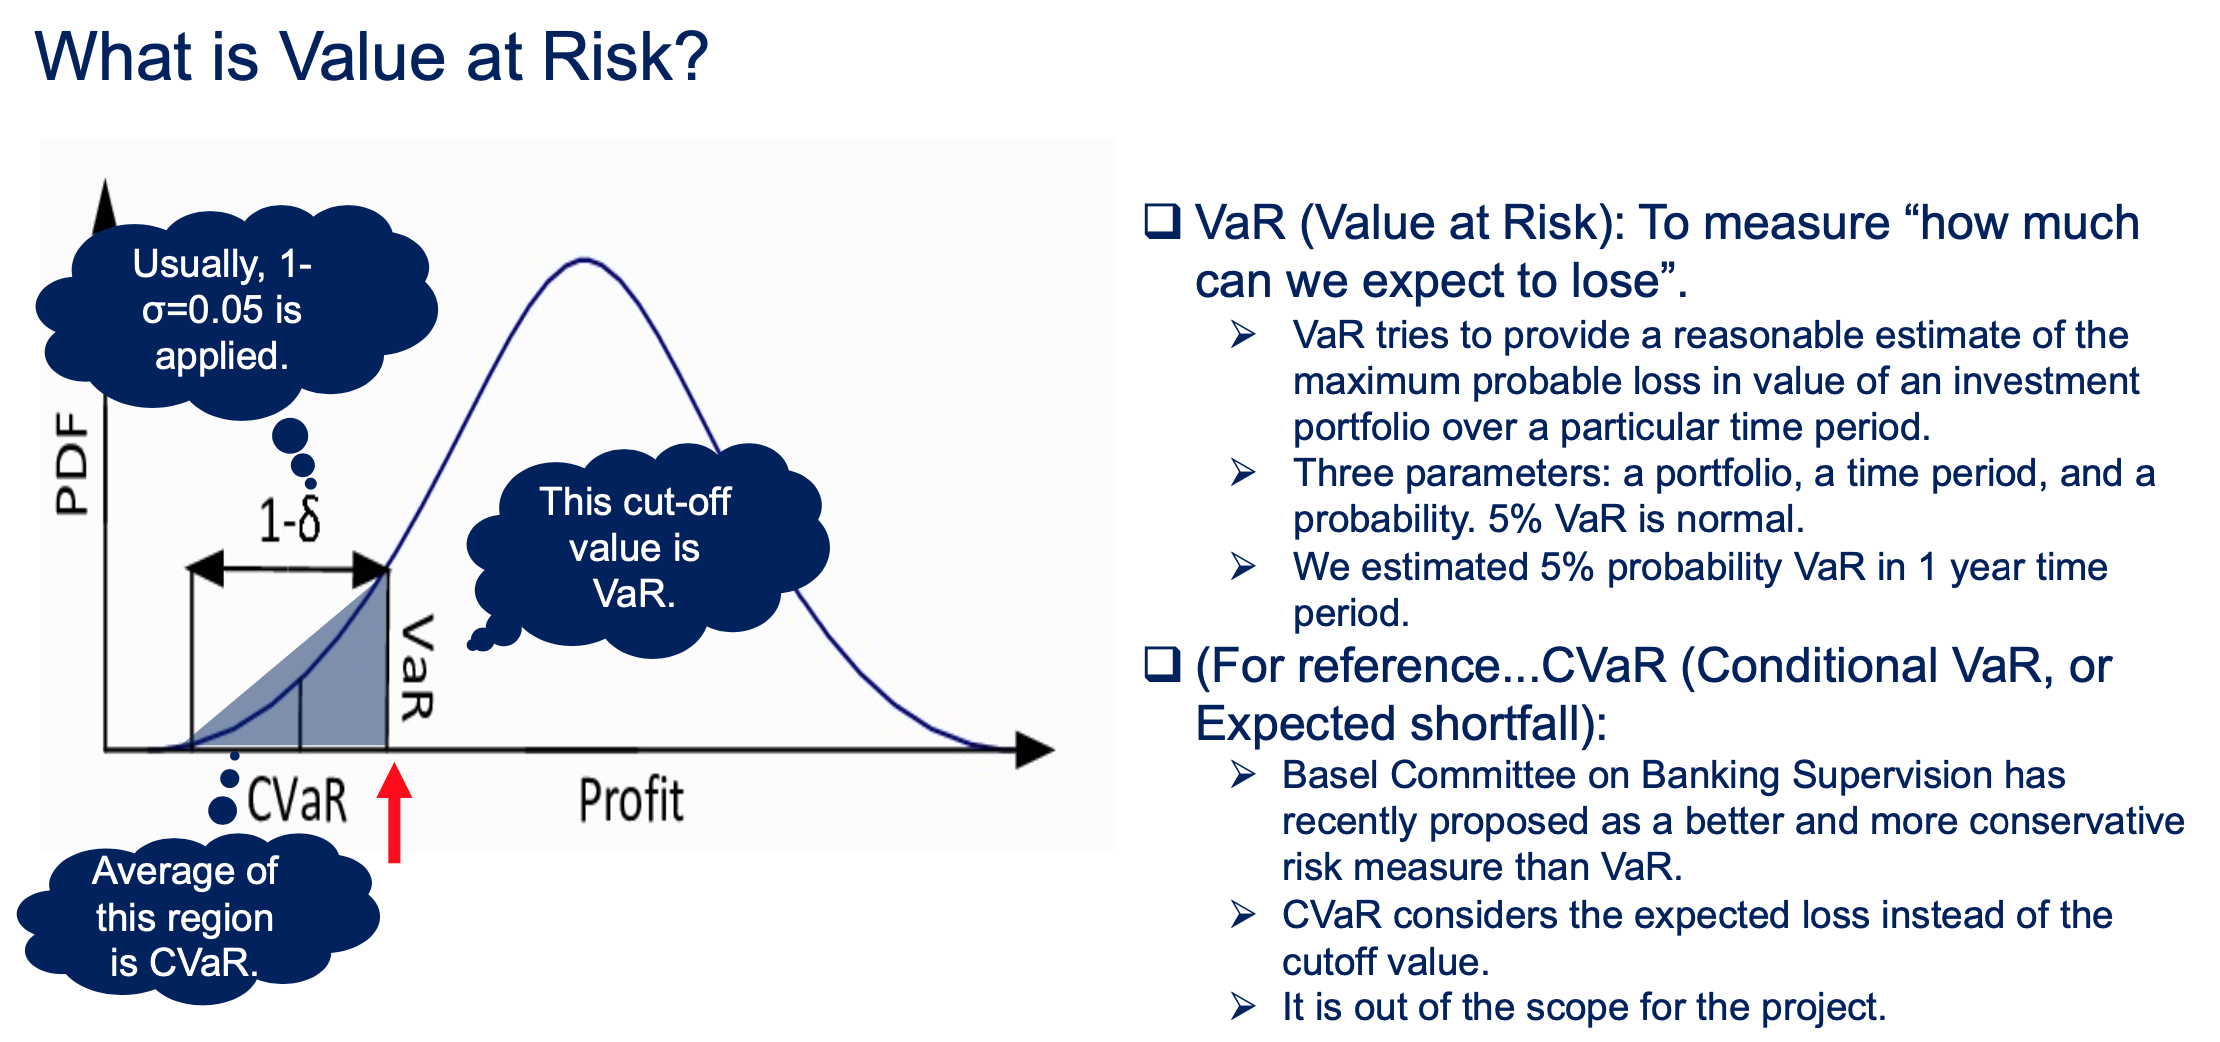

(Source: Sandy Ryza, Uri Laserson, Sean Owen, Josh Wills. Advanced Analytics with Spark. O’Reilly, 2015)

* In the risk management agent, I introduced an important concept of risk management called Value at Risk (VaR). VaR tries to provide a reasonable estimate of the maximum probable loss in value of an investment portfolio over a particular time period.

* There are 3 parameters in VaR, a portfolio, a time period, and a probability. Basically, practitioners calculate 5% VaR in a certain period (1 day, 1 month, or 1 year depending on the situation) is normal.

* Also, if you prefer more conservative risk management criteria, you can also apply CVaR, i.e. Conditional VaR, which considers the expected loss  with 5% of probability, rather than cut-off value in VaR.


There are 3 methods to implement VaR (or CVaR) as follows:

* **Variance-Covariance method:** Variance-covariance is by far the simplest and least computationally intensive method. Its model assumes that the return of each instrument is normally distributed, which allows deriving an estimate analytically just by calculating volatility of the portfolio.

* **Historical simulation method:** Historical simulation extrapolates risk from historical data by using its distribution directly instead of relying on summary statistics. For example, to determine a 95% VaR for a portfolio, we might look at that portfolio’s performance for the last 100 days and estimate the statistic as its value on the fifth-worst day as “1 day 5% VaR”. A drawback of this method is that historical data can be limited and fails to include all market scenarios such as market collapse.

* **Monte Carlo Simulation method:** Monte Carlo simulation tries to weaken the assumptions in the previous 2 methods by simulating the portfolio under random conditions. While this method is widely used in the financial risk management at banks and asset management companies, it requires much computational resources. We can utilize distributed computing such as Spark to calculate Monte Carlo VaR, while it is out of the scope for this project.

In the risk management agent, the agent calculates estimated 5% probability VaR annually i.e. in 1 year time period by variance-covariance method, because of its simple implementation and computationally cheap and fast execution.

When we apply the variance-covariance method, we need to calculate the portfolio volatility i.e. standard deviation of σ (Note: variance is the square of standard deviation). The portfolio volatility for 2 securities is shown as follows:

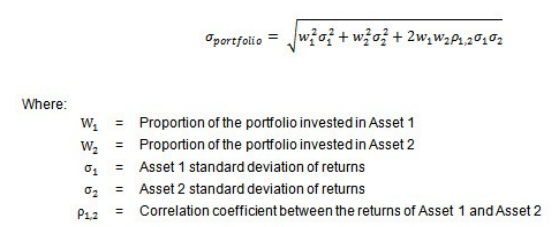

(Source:https://medium.com/python-data/assessing-the-riskiness-of-a-portfolio-with-python-6444c727c474)

* In our case, w1=cash, w2=bitcoin. Also, cash has zero volatility i.e. σ_1 = 0.

* Therefore, above equation can be simplified as follows:

 σ_portfolio = √w2^2✖️σ_2^2 = w2✖️σ_2. 

* At the functions of **def coinVaRCalc(day, var_pct=0.05)** and **def portVaRCalc(day, var_pct=0.05)** in **class riskManagement(object)**, the portfolio volatility is calculated as such.


(Note: If the portfolio can consist of multiple securities, portfolio volatility is calculated by matrix algebra shown as follows:)

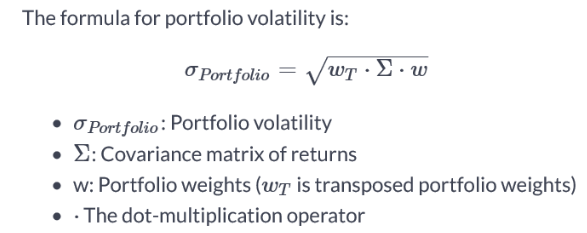

(Source:https://stackoverflow.com/questions/59462628/is-there-a-way-to-vectorize-the-portfolio-standard-deviation-in-python-pandas)

For example, above portfolio volatility of 2 securities can be shown in context of matrix algebra, as follows:

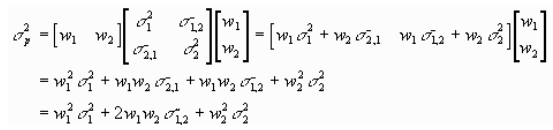

(Source:https://medium.com/python-data/assessing-the-riskiness-of-a-portfolio-with-python-6444c727c4 74)

While dealing with multiple securities or multi asset classes is out of scope this time, we can implement VaR with multiple securities or multi asset classes using the above matrix algebra formula relatively easily with Python. Also, while CVaR and monte carlo simulation methods are out of the scope in this project, it is worth introducing as those are often used by industry practitioners, such that I also introduced those just for reference.

### 2.Position sizing using VaR

* After we can calculate the portfolio of VaR, we can decide the position size using VaR. For example, the CEO agent sets the maximum VaR limit = 0.2 (20% of loss in 1 year with 5% of probability), we can take the position as such, by calculating follows:

 σ_portfolio = weight of bitcoin in total NAV*σ_bitcoin

 s.t.

 the weight of bitcoin in total NAV = σ_portfolio / σ_bitcoin.

 The system implements such a function at **def targetPositionFromVaR(day, VaRLimit, var_pct=0.05)** in in **class riskManagement(object)**. In this function, using above logic, the target bitcoin’s position size is calculated by Target Coin Value = NAV*VaR_limit / VaR_bitcoin.

* As you can infer, the bitcoin volatility σ_bitcoin can change over time as the degree of market fluctuation of bitcoin changes, such that our portfolio volatility σ_portfolio can change over time.

* The CEO function can decide the position sizing using this function, and can rebalance the portfolio using this function, i.e. if the VaR becomes too large at the current position size in terms of VaR limit, the system can slush the position size, and vice versa.

* It is the operation that many institutional investors actually do in daily portfolio management, such that I implemented such a function to introduce such basic portfolio management activities in the financial and investment management industries.

### Code of the agent

In [ ]:
class riskManagement(object):

  ##########################
  #Value At Risk related
  #risk management tools
  ##########################

  #calculate crypto's volatility and VaR, annualized
  def coinVaRCalc(day, var_pct=0.05):
    price_df = Broker.longHistoryPriceGetter()

    last_day = day
    past1m = last_day + datetime.timedelta(days=-30)
    daily_volatility = price_df.loc[(price_df.index >= past1m) & (price_df.index <= last_day),'pct_change'].std()
    #Converting daily volatility into annual volatility.
    annual_volatility = daily_volatility * np.sqrt(365)
    #Calculate 1 year VaR under var_pct=0.05 (default)
    #norm.ppf(0.95) can return standard deviation at lower 5% point in 
    #gaussian distribution. norm.ppf(0.95) = 1.65, norm.ppf(0.99)=2.32
    var_calc = - annual_volatility * norm.ppf(1-var_pct)

    return var_calc

  @staticmethod
  def portVaRCalc(day, var_pct=0.05):
    #calculate crypto's VaR
    coin_var = riskManagement.coinVaRCalc(day, var_pct=0.05)
    #check this day's coin_value, nav
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]
    coin_value = Account.getTradeInfoDf().loc[indexRow,'coin_value']
    nav = Account.getTradeInfoDf().loc[indexRow,'nav']
    #calculate how much % of portfolio is crypto
    coin_port_pct = coin_value / nav
    #portfolio VaR is calculated by coin_var * coin_port_pct
    port_var = coin_var * coin_port_pct

    return port_var

  @staticmethod
  def targetPositionFromVaR(day, VaRLimit, var_pct=0.05):
    #calculate crypto's VaR
    coin_var = riskManagement.coinVaRCalc(day, var_pct)
    #check yesterday's nav
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]
    nav = Account.getTradeInfoDf().loc[indexRow,'nav']
    #calculate target crypto's position size from CEO's VaRLimit
    target_coin_value = nav * np.abs(VaRLimit) / np.abs(coin_var)
    #check last day's coin_value, nav
    lastday_last_price = Account.getTradeInfoDf().loc[indexRow,'last_price']
    #calculate target position size
    target_num_coin = target_coin_value / lastday_last_price

    return target_num_coin

  ##########################
  #Target profit and loss tolerance related
  #risk management tools
  ##########################

  #If NAV reaches to certain loss / profit amount, CEO will decide to
  #stop trading.
  @staticmethod
  def riskManagementAssets(day,lossTolerance, profitTarget):
      initialNAV = PNLAgent.getInitialNAV()
      currentNAV = PNLAgent.getTodayNAV(day)
      PnLPercent = currentNAV / initialNAV - 1.0
      
      if PnLPercent <= lossTolerance or PnLPercent >= profitTarget:
          return True
      return False

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

## Data visualization and RPA agent

* Data visualization and RPA (Robotic Process Automation) are also important parts in business operational flow.

* By data visualization with several graphs and charts, we can recognize what’s going on in the market and our portfolio easily and can make decisions toward the market timely (such as the human decision making of whether we should stop working the trading system etc).

* Also, we can improve efficiency of daily operation by automating repetitive operations such as sending monthly reports by email and storing attached files in email to specific data storage (such as One Drive).

* This agent takes those tasks such as data visualization and RPA. I introduced PowerBI for data visualization and Power Automate for RPA. Those Microsoft products are widely used, such that we can utilize those in our workplace to improve operational efficiency.

### 1.Data visualization by PowerBI

In the data visualization tool, Tableau and PowerBI are popularly used in business corporations, and the PowerBI is the one which is released by Microsoft. With regard to the basic usage and how-to, we can refer to Microsoft’s website as follows. You can learn how to create and manage Report and Account in Power BI to visualize our data with graphs and charts.

Get started using Power BI
https://docs.microsoft.com/en-us/users/microsoftpowerplatform-5978/collections/k8xidwwnzk1em

After setting Power BI and executing below code, we can see the data updated like the following picture at the “Report” which is linked with the “Account” file.

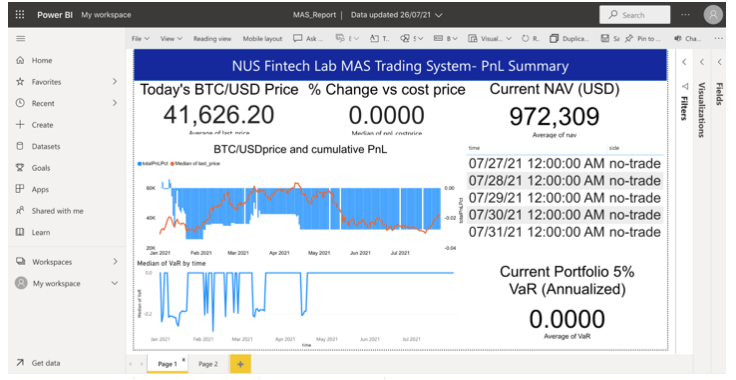

### 2.RPA by PowerAutomate

Robotic process automation (RPA) is a technology that mimics and automates the way humans interact with software to perform high-volume, repeatable tasks. While there are many RPA software and services available, Microsoft Power Automate is a convenient solution for RPA, especially as we would like to automate operations around softwares and services of Microsoft family (i.e. Office 365, One Drive etc). With regard to the basics of how-to and what we can do by Power Automate, we can refer to the following tutorials from Microsoft.

Get started with Power Automate
https://docs.microsoft.com/en-us/power-automate/getting-started

* On the other hand, unfortunately, Power Automate cannot set Google Drive and google Colab as the trigger of doing automated action.

* Also, with regard to the frequently used function such as sending email automatically, we can write code to send email automatically.

* So, I introduced the code to send email automatically at **def outlookSend(file_name)** in class **dataVisualRPA(object)**.

* As a result, the system automated the monthly report sending and storing tasks by Python code and Power Automate shown in the following picture. We can reduce the cost and improve daily efficiency significantly by RPA, such that we can utilize this skill at the daily workplace.

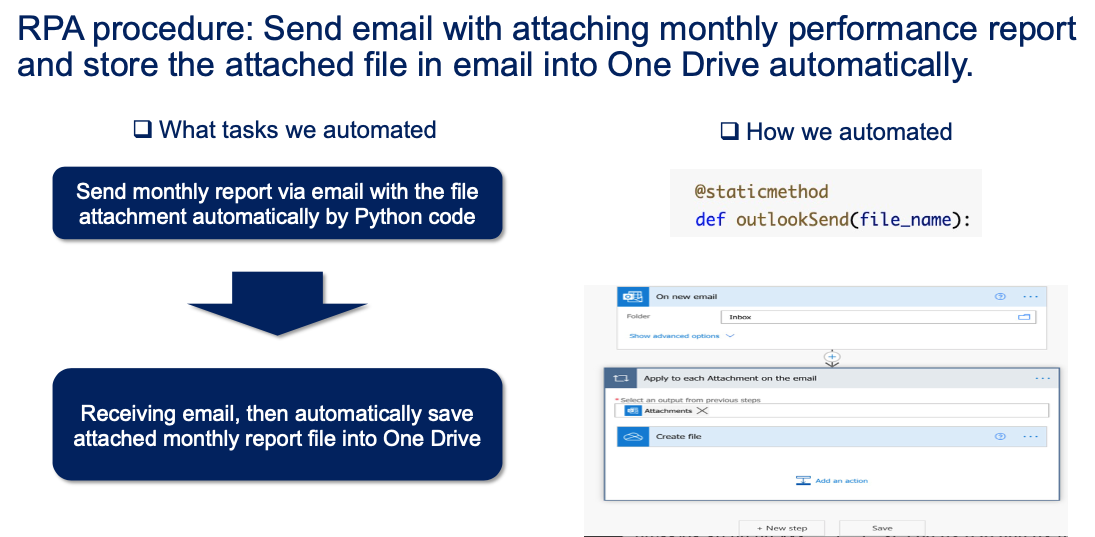

### Code of the agent

In [ ]:
class dataVisualRPA(object):
  
  # Visualization in PowerBI
  @staticmethod
  def visualizationPowerBI():
    #use your own PowerBI url
    url ='xxxxxx'

    # Prepare all the data
    #Account book information
    day =Account.getTradeInfoDf()['time'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
    side =Account.getTradeInfoDf()['side'].iloc[-1]
    exec_price =Account.getTradeInfoDf()['exec_price'].iloc[-1].astype('float64')
    last_price =Account.getTradeInfoDf()['last_price'].iloc[-1].astype('float64')
    cost_price =Account.getTradeInfoDf()['cost_price'].iloc[-1].astype('float64')
    pnl_costprice =Account.getTradeInfoDf()['pnl_costprice'].iloc[-1].astype('float64')
    quantity =Account.getTradeInfoDf()['quantity'].iloc[-1].astype('float64')
    num_coins = Account.getTradeInfoDf()['num_coins'].iloc[-1].astype('float64')
    coin_value = Account.getTradeInfoDf()['coin_value'].iloc[-1].astype('float64')
    cash = Account.getTradeInfoDf()['cash'].iloc[-1].astype('float64')
    nav = Account.getTradeInfoDf()['nav'].iloc[-1].astype('float64')
    dailyPnL = Account.getTradeInfoDf()['dailyPnL'].iloc[-1].astype('float64')
    dailyPnLPct = Account.getTradeInfoDf()['dailyPnLPct'].iloc[-1].astype('float64')
    totalPnL = Account.getTradeInfoDf()['totalPnL'].iloc[-1].astype('float64')
    totalPnLPct = Account.getTradeInfoDf()['totalPnLPct'].iloc[-1].astype('float64')    
    VaR_annualized = Account.getTradeInfoDf()['VaR_annualized'].iloc[-1].astype('float64')

    #Decider recommendation info
    report_ceo = cbrDecider.signalToCEOGetter()['report_ceo'].iloc[-1].astype('float64')

    #Each agent info
    agent1_long = cbrDecider.allSignalsGetter()['agent1_long'].iloc[-1].astype('float64')
    agent1_short = cbrDecider.allSignalsGetter()['agent1_short'].iloc[-1].astype('float64')
    agent2_long = cbrDecider.allSignalsGetter()['agent2_long'].iloc[-1].astype('float64')
    agent2_short = cbrDecider.allSignalsGetter()['agent2_short'].iloc[-1].astype('float64')
    agent3_long = cbrDecider.allSignalsGetter()['agent3_long'].iloc[-1].astype('float64')
    agent3_short = cbrDecider.allSignalsGetter()['agent3_short'].iloc[-1].astype('float64')

    agent1_PF = cbrDecider.allSignalsGetter()['agent1_PF'].iloc[-1].astype('float64')
    agent2_PF = cbrDecider.allSignalsGetter()['agent2_PF'].iloc[-1].astype('float64')
    agent3_PF = cbrDecider.allSignalsGetter()['agent3_PF'].iloc[-1].astype('float64')

    agent1_weight = cbrDecider.allSignalsGetter()['agent1_weight'].iloc[-1].astype('float64')
    agent2_weight = cbrDecider.allSignalsGetter()['agent2_weight'].iloc[-1].astype('float64')
    agent3_weight = cbrDecider.allSignalsGetter()['agent3_weight'].iloc[-1].astype('float64')

    data = [
            {"time": day,
             "side": side,
             "exec_price": exec_price,
             "last_price": last_price,
             "cost_price": cost_price,
             "pnl_costprice": pnl_costprice,
             "num_coins": num_coins,
             "nav": nav,
             "totalPnL": totalPnL,
             "totalPnLPct": totalPnLPct,
             "VaR": VaR_annualized,
             "report_ceo": report_ceo,
             "agent1_long": agent1_long,
             "agent1_short": agent1_short,
             "agent2_long": agent2_long,
             "agent2_short": agent2_short,
             "agent3_long": agent3_long,
             "agent3_short": agent3_short,
             "agent1_PF": agent1_PF,
             "agent2_PF": agent2_PF,
             "agent3_PF": agent3_PF,
             "agent1_weight": agent1_weight,
             "agent2_weight": agent2_weight,
             "agent3_weight": agent3_weight
             }
            ]

    headers = {"Content-Type": "application/json"}
    response = requests.request(
      method="POST",
      url= url,
      headers=headers,
      data=json.dumps(data)
    )
  
  '''
  ###################
  #Just for reference
  #If you'd like to send gmail, pls refer follows
  ###################
  @staticmethod
  def gmailSend(file_name):
    #Set gmail account. Please use your own account when in use.
    gmail_account = "xxxxxx@gmail.com"
    #we need set 16 digits of application password at gmail side
    gmail_password = 'password'
    #Set email address to send to
    mail_to = "xxxxxx@gmail.com"
    #File attachment
    file_path = 'data_sendmail/' + file_name

    #Creating E-mail data (MIME)
    subject = "Performance Report"
    body = "Attached file is the monthly performance."
    encoding = 'utf-8'
    msg = MIMEMultipart()
    msg["Subject"] = Header(subject, encoding)
    msg["To"] = mail_to
    msg["From"] = gmail_account
    msg.attach(MIMEText(body, 'plain', encoding))

    #Attach csv file to email
    attach = MIMEBase('application','csv')
    with open(file_path, "br") as f:
        attach.set_payload(f.read())
    encoders.encode_base64(attach)
    attach.add_header('Content-Disposition', 'attachment',
        filename= file_name)
    msg.attach(attach)

    #Connect to Gmail
    server = smtplib.SMTP_SSL("smtp.gmail.com", 465,
        context=ssl.create_default_context())
    #login
    server.login(gmail_account, gmail_password)
    #send email
    server.send_message(msg)
    #exit from server
    server.quit()
    '''

  @staticmethod
  def outlookSend(file_name):
    #set smtp host and port of outlook
    smtp_host = 'smtp.office365.com'
    smtp_port = 587
    #set email address of from and to
    from_email = 'xxxxxx@u.nus.edu'
    to_email = 'xxxxxx@u.nus.edu'
    #username and pass for "from" email address
    #enter your own NUS email and password
    username = 'xxxxxx@u.nus.edu'
    password = 'xxxxxxxxxx'

    #email contents (subject, body message, etc)
    subject = 'Performance Report, attached with ' + file_name
    body = "Attached file is the monthly performance."
    encoding = 'utf-8'
    msg = MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email
    msg.attach(MIMEText(body, 'plain', encoding))

    #Attach csv file to email
    #File attachment
    file_path = 'data_sendmail/' + file_name
    attach = MIMEBase('application','csv')
    with open(file_path, "br") as f:
        attach.set_payload(f.read())
    encoders.encode_base64(attach)
    attach.add_header('Content-Disposition', 'attachment',
        filename= file_name)
    msg.attach(attach)

    #establish the connection with smtp server
    server = smtplib.SMTP(smtp_host, smtp_port)
    server.ehlo()
    server.starttls()
    server.ehlo()
    #login into "from" email account with username and password
    server.login(username, password)
    #send email
    server.send_message(msg)
    #close the connection with server
    server.quit()

  @staticmethod
  def sendMonthlyReport(day):
    #set monthly data scope within this month
    monthly_account_df = Account.getTradeInfoDf()[(Account.getTradeInfoDf()['time'] >= datetime.datetime(day.year,day.month,1))\
                                               & (Account.getTradeInfoDf()['time'] <= day)]
    #set fila name based on the day of month-end
    file_name = 'MonthlyReport_' + day.strftime('%Y%m%d') + '.csv'
    #create csv file
    monthly_account_df.to_csv('data_sendmail/' + file_name)
    #send csv file
    dataVisualRPA.outlookSend(file_name)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

## CEO agent

Finally, we reached the final agent, the CEO agent.

* First, the CEO agent establishes investment and risk management policy at ceoInitialSetUp() function. CEO sets up initial fund amount, starting day, risk management policy such as annualized VaR limit, and profit target/maximum loss tolerance when the fund terminates trading if it reaches to that point. Such investment and risk policy are set before we start daily trading and fund management activities in the real world of fund management too.

* Then, the CEO agent orchestrates the buy/sell recommendation from the Decider agent, Account recording by Account agent, risk management from Risk management agent, and makes final trading decisions and asks trade execution to the Broker agent.

### Code of the agent

In [ ]:
class CEO(object):

  @staticmethod
  def ceoInitialSetUp():
    #Account initialization
    num_coins = 0
    funds = 1000000
    #day setting
    CEO.firstDay = True
    startday = datetime.datetime(2021, 1, 1)
    tMinus1day = startday + datetime.timedelta(days=-1)
    tMinusYrs = datetime.datetime(2019,1,1)
    
    #setting account book
    Account.initialization(num_coins, funds, startday)
    #obtain price data
    Broker.histPriceAcquisition()
    #macro data initialization
    macroEconomist.dataInitilization(tMinusYrs)
    macroEconomist.backtestPrep(tMinusYrs,tMinus1day)
    #training last years to optimize the parameters for 3 signaling agents
    CEO.final_training_list = backTest.tradingPrepTraining(tMinusYrs,tMinus1day)
    #initialize 3 signaling agents for trading    
    CEO.movingAvg_strat =  stratPnL(startday, CEO.final_training_list[0][1][0], CEO.final_training_list[0][1][1],
                                test=True, test_initial_df=CEO.final_training_list[0][2])
    CEO.bollinger_strat =  stratPnL(startday, CEO.final_training_list[1][1][0], CEO.final_training_list[1][1][1],
                                test=True, test_initial_df=CEO.final_training_list[1][2])
    CEO.twitter_strat =  stratPnL(startday, CEO.final_training_list[2][1][0], CEO.final_training_list[2][1][1],
                                test=True, test_initial_df=CEO.final_training_list[2][2])

    CEO.quantSignal_realtime = quantsSignal(backtest=False)
    CEO.tweet_signal_realtime = twitterSignal(startday,backtest=False)

    #decider initialization
    cbrDecider.deciderInitialization(CEO.final_training_list, startday)
    
    #######################
    #Initialize risk management policy
    #######################
    #Maximum VaR Limit, annual volatility based
    #In normal situation
    CEO.VaRLimitNormal = -0.2
    #When Decider recommend 5 i.e. strong buy with high conviction
    CEO.VaRLimitAggressive = -0.5

    # Percent of total assets loss/profit in which CEO will consider stop trading
    # (risk management in terms of total assets)
    CEO.lossTolerance = -0.5
    CEO.profitTarget = 10.0

  #daily update for whole process above
  def dailyDeciderUpdate(day):
    #update daily crypto market price, Broker.longhist_price_df
    #PNLAgent.dailyMarketUpdate(day)
    #update the price for case based reasoning i.e. cbrDecider.coin_price_df
    cbrDecider.dailyCasePriceUpdate(day)
    #update each signaling agent's signal i.e. quantSignal_realtime.agent1_hist_signal_df,
    #quantSignal_realtime.agent2_hist_signal_df, tweet_signal_realtime.agent3_hist_signal_df
    CEO.quantSignal_realtime.movingAvgDailyUpdate(day,CEO.final_training_list[0][0][0],CEO.final_training_list[0][0][1])
    CEO.quantSignal_realtime.bollingerDailyUpdate(day,CEO.final_training_list[1][0][0],CEO.final_training_list[1][0][1])
    CEO.tweet_signal_realtime.dailyUpdate(day,5,CEO.final_training_list[2][0][0],CEO.final_training_list[2][0][1])
    #calculate daily PnL for each strategy i.e. movingAvg_strat.df, bollinger_strat.df, twitter_strat.df
    CEO.movingAvg_strat.updateProfitLoss(day, CEO.quantSignal_realtime.agent1SignalGetter())
    CEO.bollinger_strat.updateProfitLoss(day, CEO.quantSignal_realtime.agent2SignalGetter())
    CEO.twitter_strat.updateProfitLoss(day, CEO.tweet_signal_realtime.agent3SignalGetter())

    #put each signal's data into decider agent
    cbrDecider.updateSignals(day, CEO.movingAvg_strat.dfGetter(), CEO.bollinger_strat.dfGetter(), CEO.twitter_strat.dfGetter())
    #update macroEconomist's 3 factors data
    macroEconomist.dailyUpdate(day)
    cbrDecider.updateMacro(day)
    #concatenate 3 signaling agents and macro economist's data.
    #The dataframe of cbrDecider.signal_macro_df is updated.
    cbrDecider.updateNewCaseData(day)
    #update final recommendation to CEO, based on CBR
    #The dataframe of cbrDecider.signal_to_ceo_hist_df is updated.
    cbrDecider.dailyReportToCEO(day)
    #update case data
    #cbrDecider.case_data_df is updated
    cbrDecider.caseUpdate(day)

  #Daily market update
  #updating tool for the day with buy/sell trading
  @staticmethod
  def tradeUpdateTool(time,side, exec_price, quantity):

    #temporally set as zero. Those figures are calculated later
    nav = 0.0
    dailyPnL = 0.0
    dailyPnLPct = 0.0
    totalPnL = 0.0
    totalPnLPct = 0.0
    VaR_annualized = 0.0

    #creating today's account balance
    Broker.tradeExecution(time,side, exec_price, quantity, nav, dailyPnL, 
                          dailyPnLPct, totalPnL, totalPnLPct, VaR_annualized)
    #update last_price
    PNLAgent.updateLastPrice(time)
    #update NAV for today
    PNLAgent.calculateNAV(time)

  #decider_recom_diff = difference between today and yesterday's decider
  #recommendation i.e. 4->4, 3->3 etc =0, 3->4, 4->5 etc = 1, 4->3, 3->2 etc=-1
  @staticmethod
  def dailyMarketUpdate(day):

    ####################
    #rebalanse = False as default
    ####################
    rebalanceBuy = False
    rebalanceSell = False

    ####################
    #Acquire basic information
    ####################
    #if it's first day, just update whole information and no trade
    if CEO.firstDay == True:
      #run daily whole update before running
      CEO.dailyDeciderUpdate(day)

      #update last_price of Account book    
      PNLAgent.updateLastPrice(day)
      #update NAV of Account book
      PNLAgent.calculateNAV(day)

      #Change flag regarding whether it's first day of trade
      CEO.firstDay = False

    #else, operate daily update and make trade if signal is buy/sell
    else:     
      #day acquisition
      yesterday = day + datetime.timedelta(days=-1)
      today = day
      #check yesterday's num_coin
      indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == yesterday].index.values[0]
      num_coins = Account.getTradeInfoDf().loc[indexRow,'num_coins']

      ####################
      #CEO's discussion with risk management agent
      ####################

      ####################
      #Risk management:Return since inception
      ####################

      #check total return since inception
      tradeKill = riskManagement.riskManagementAssets(yesterday,
                                                        CEO.lossTolerance,
                                                        CEO.profitTarget)
      #if return since inception reaches to max loss tolerance or profit target,
      #we kill the trade.
      if tradeKill == True:
        return print("Now we reached to max loss / profit target. Exit trade.")


      #update the recommendation and CBR case from decider
      #moving average, bollinger band, twitter agents are updated
      #macroEconomist agent update macro economic data
      #return final recommendation to CEO from decider agent,
      #by updating cbrDecider.signal_to_ceo_hist_df
      CEO.dailyDeciderUpdate(today)

      #receive recommendation from decider
      decider_recom = cbrDecider.signalToCEOGetter().loc[today,'report_ceo']
      decider_recom_diff = cbrDecider.signalToCEOGetter().loc[today,'report_ceo_diff']

      ####################
      #Risk management:Position sizing using VaR
      # and conviction of recommendation
      ####################

      #check current recommendation from decider.
      #if decider is strong buy = 5, CEO will increase VaRLimit.
      if decider_recom == 5:
        currentVaRLimit =  CEO.VaRLimitAggressive
      #if decider is normal buy or less i.e. 1-4, CEO will apply normal VaRLimit.
      else:
        currentVaRLimit =  CEO.VaRLimitNormal

      #check target position size by VaR
      target_num_coins = riskManagement.targetPositionFromVaR(yesterday, currentVaRLimit)

      #If buy recommendation but the position size is too much, slushing the position
      if (num_coins - target_num_coins >= 1.0) & (decider_recom > 3.5):
        rebalanceSell = True
      #If buy recommendation and the position size is too small, increase the position
      if (num_coins - target_num_coins <= -1.0) & (decider_recom > 3.5):
        rebalanceBuy = True

      ####################
      #Trade execution with Broker agent 
      ####################

      #Buy trading
      if (decider_recom > 3.5) & (decider_recom_diff > 0.5 or rebalanceBuy == True):
        side = 'buy'
        exec_price = Broker.get_pseudo_ask_price(today)
        #position size is determined by risk management agent.
        quantity = riskManagement.targetPositionFromVaR(yesterday, currentVaRLimit) - num_coins

        CEO.tradeUpdateTool(today,side, exec_price, quantity)

      #sell trading day.
      elif ((decider_recom < 3.5) & (decider_recom_diff < -0.5)) or rebalanceSell == True:
        side = 'sell'
        exec_price = Broker.get_pseudo_bid_price(today)
        #if rebalanceSell = True, not selling everything.
        if rebalanceSell == True:
          quantity = np.abs(num_coins - riskManagement.targetPositionFromVaR(yesterday, currentVaRLimit))
        #if decider's decision to sell, sell all
        else:
          quantity = num_coins

        CEO.tradeUpdateTool(today,side, exec_price, quantity)

      #Daily update for no trading day.
      else:
        exec_price = 0
        #last price is updated later
        last_price = 0
        #creating today's account balance
        Account.updateNoTradeDay(today, exec_price, last_price)
        #update last_price
        PNLAgent.updateLastPrice(today)
        #update NAV for today
        PNLAgent.calculateNAV(today)

    #Finally, sending data to PowerBI.
    dataVisualRPA.visualizationPowerBI()
    #if it's the last day of month, sending monthly report via email
    today_month = day.month
    nextday = day + datetime.timedelta(days=1)
    nextday_month = nextday.month
    if today_month < nextday_month:
      dataVisualRPA.sendMonthlyReport(day)

Initializing CEO agent

In [ ]:
CEO.ceoInitialSetUp()

Run daily trade

In [ ]:
day = datetime.datetime(2021,1,1)
while day <= datetime.datetime(2021,7,31):
  CEO.dailyMarketUpdate(day)
  day = day + datetime.timedelta(days=1)

In [ ]:
cbrDecider.caseDataGetter().tail()

In [ ]:
cbrDecider.signalToCEOGetter().head()

In [ ]:
Account.getTradeInfoDf().tail()

In [ ]:
cbrDecider.allSignalsGetter().tail()

In [ ]:
cbrDecider.allSignalsGetter().loc[:,['agent1_weight','agent2_weight','agent3_weight']].plot()

In [ ]:
cbrDecider.allSignalsGetter().loc[:,['agent1_PF','agent2_PF','agent3_PF']].plot()

In [ ]:
cbrDecider.allSignalsGetter().loc[:,['decider_rating']].plot()

## Disclaimer

This document is provided for information purposes only to eligible recipients. **This document shall not constitute an offer to sell or the solicitation of any offer to buy any interest. The author is not responsible for any loss or damage arising from any investment or any other activities based on any information contained here.**
